# Cluster Cricket Strokes based on optical flow

## Description:

Taking the highlight videos and the stroke labels, extract optical flow data from the strokes and cluster them to find inherent stroke categories.

In [1]:
from __future__ import print_function

import os
import seaborn as sns
import cv2
import sys
import json
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt

#from utils import crop_centre
from itertools import permutations
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans, DBSCAN
sns.set()

%matplotlib inline

c3dWinSize = 22
# Local Paths
LABELS = "/home/arpan/VisionWorkspace/Cricket/scripts/supporting_files/sample_set_labels/sample_labels_shots/ICC WT20"
DATASET = "/home/arpan/VisionWorkspace/VideoData/sample_cricket/ICC WT20"
#c3dFC7FeatsPath = "/home/arpan/VisionWorkspace/Cricket/localization_finetuneC3D/c3dFinetuned_feats_"+str(c3dWinSize)
# Server Paths
if os.path.exists("/opt/datasets/cricket/ICC_WT20"):
    LABELS = "/home/arpan/VisionWorkspace/shot_detection/supporting_files/sample_set_labels/sample_labels_shots/ICC WT20"
    DATASET = "/opt/datasets/cricket/ICC_WT20"
    #c3dFC7FeatsPath = "/home/arpan/VisionWorkspace/localization_finetuneC3D/c3dFinetuned_feats_"+str(c3dWinSize)

ANNOTATION_FILE = "stroke_labels.txt"
flow_numpy_path = 'flow_numpy_files'
RESULTS_DIR = 'res_OF_clusters'

## 1. Extract flow maps and write to disk

In [2]:
def extract_all_feats(vidsPath, labelsPath, nbins, mag_thresh=5):
    """
    Function to iterate on all the training videos and extract the relevant features.
    vidsPath: str
        path to the dataset containing the videos
    labelsPath: str
        path to the JSON files for the labels.
    mag_thresh: float
        pixels with >mag_thresh will be considered significant and used for clustering
    nbins: int
        No. of bins in which the angles have to be divided.
    """
    video_files = sorted(os.listdir(vidsPath))
    json_files = sorted(os.listdir(labelsPath))
    all_feats = None
    bins = np.linspace(0, 2*np.pi, (nbins+1))
    for i, v_file in enumerate(video_files):
        print('-'*60)
        print(str(i+1)+". v_file :: ", v_file)
        video_name = v_file.rsplit('.', 1)[0]
        #print("video_name :: ", video_name)
        json_file = video_name + '.json'
        #print("json file :: ", json_file)
        
        # read labels from JSON file
        if json_file not in json_files:
            print("json file not found!")
            sys.exit(0)
        with open(os.path.join(LABELS, json_file), 'r') as fr:
            frame_dict = json.load(fr)
        frame_indx = list(frame_dict.values())[0]
        #print('frame_indx :: ', frame_indx)

        #f_loc = os.path.join(flow_numpy_path, video_name)
        stroke_features = extract_flow_angles(os.path.join(DATASET, v_file), frame_indx, bins, mag_thresh)
        if all_feats is None:
            all_feats = stroke_features
        else:
            all_feats = np.vstack((all_feats, stroke_features))
        #break
    return all_feats



In [3]:
def extract_flow_angles(vidFile, frame_indx, hist_bins, mag_thresh):
    '''
    Extract optical flow maps from video vidFile for all the frames and put the angles with >mag_threshold in different 
    bins. The bins vector is the feature representation for the stroke. 
    Use only the strokes given by list of tuples frame_indx.
    Parameters:
    ------
    vidFile: str
        complete path to a video
    frame_indx: list of tuples (start_frameNo, end_frameNo)
        each tuple in the list denotes the starting frame and ending frame of a stroke.
    hist_bins: 1d np array 
        bin divisions (boundary values). Used np.linspace(0, 2*PI, 11) for 10 bins
    mag_thresh: int
        minimum size of the magnitude vectors that are considered (no. of pixels shifted in consecutive frames of OF)
    
    '''
    
    cap = cv2.VideoCapture(vidFile)
    if not cap.isOpened():
        print("Capture object not opened. Aborting !!")
        sys.exit(0)
    ret = True
    stroke_features = []
    prvs, next_ = None, None
    for m, n in frame_indx:   #localization tuples
        
        #print("stroke {} ".format((m, n)))
        sum_norm_mag_ang = np.zeros((len(hist_bins)-1))  # for optical flow maxFrames - 1 size
        frameNo = m
        while ret and frameNo <= n:
            if (frameNo-m) == 0:    # first frame condition
                cap.set(cv2.CAP_PROP_POS_FRAMES, frameNo)
                ret, frame1 = cap.read()
                if not ret:
                    print("Frame not read. Aborting !!")
                    break
                # resize and then convert to grayscale
                #cv2.imwrite(os.path.join(flow_numpy_path, str(frameNo)+".png"), frame1)
                prvs = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
                #prvs = scale_and_crop(prvs, scale)
                frameNo +=1
                continue
                
            ret, frame2 = cap.read()
            #cv2.imwrite(os.path.join(flow_numpy_path, str(frameNo)+".png"), frame2)
            # resize and then convert to grayscale
            next_ = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
            
            flow = cv2.calcOpticalFlowFarneback(prvs, next_, None, 0.5, 3, 15, 3, 5, 1.2, 0)
            mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
            
            #print("Mag > 5 = {}".format(np.sum(mag>THRESH)))
            pixAboveThresh = np.sum(mag>mag_thresh)
            #use weights=mag[mag>THRESH] to be weighted with magnitudes
            #returns a tuple of (histogram, bin_boundaries)
            ang_hist = np.histogram(ang[mag>mag_thresh], bins=hist_bins)
            sum_norm_mag_ang +=ang_hist[0]
#            if not pixAboveThresh==0:
#                sum_norm_mag_ang[frameNo-m-1] = np.sum(mag[mag > THRESH])/pixAboveThresh
#                sum_norm_mag_ang[(maxFrames-1)+frameNo-m-1] = np.sum(ang[mag > THRESH])/pixAboveThresh
            frameNo+=1
            prvs = next_
        stroke_features.append(sum_norm_mag_ang/(n-m+1))
    cap.release()
    #cv2.destroyAllWindows()
    stroke_features = np.array(stroke_features)
    return stroke_features


In [4]:

def apply_PCA(flows):
    pca = PCA(n_components=2)
    pca.fit(flows)
    flows_pca = pca.transform(flows)
    return flows_pca

def apply_tsne(flows):
    return TSNE(n_components=2).fit_transform(flows)

def kmeans(flows, clusters=4):
    km = KMeans(n_clusters=clusters, algorithm='elkan', random_state=0)
    km.fit(flows)
    return km

def dbscan(flows, clusters=4):
    db = DBSCAN(eps=0.05, min_samples=10).fit(flows)
    return db


In [18]:
def plot_clusters(data, labels, best_tuple, bins, thresh, plotname):
    n_clusters = max(labels) + 1
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    markers = list("12348spphH+xXdD")
    for color,n_cluster in enumerate(best_tuple):
        # print("n_cluster", n_cluster)
        # print("marker", markers[n_cluster])
        #label_str = "Ambiguous"
        #if color==0:
        #    label_str = "Left"
        #elif color==1:
        #    label_str = "Right"
            
        cls_data = data[labels==n_cluster]
        plt.scatter(cls_data[:,0], cls_data[:,1], c=colors[color%8], marker = markers[color], label="C"+str(color+1))
    plt.legend(loc='upper right')
    if plotname=='cluster_pca_ordered.png':
        plt.xlim((-1,1))
        plt.ylim((-1,1))
    plt.savefig(os.path.join(RESULTS_DIR, "bins_"+str(bins)+"_th_"+str(thresh), str(n_clusters)+'_'+plotname))
    plt.show()

def plot_sse_score(sse_list, x, bins, thresh):
    plt.figure(2)
    plt.xlabel("#Clusters")
    plt.ylabel("SSE")
    plt.plot(x, sse_list, label='sse score', c='r')
    plt.title('SSE score Vs No. of clusters')
    plt.savefig(os.path.join(RESULTS_DIR, "bins_"+str(bins)+"_th_"+str(thresh), 'sse_plot.png'))
    plt.show()
    

In [6]:
def visualize_of(mag, ang, frameNo):
    c = 3
    h, w = mag.shape
    hsv = np.zeros((h, w, c), dtype=np.uint8)
    hsv[...,1] = 255
    hsv[...,0] = ang*180/np.pi/2
    hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    bgr = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
    plt.figure()
    plt.imshow(bgr)
    cv2.imwrite(os.path.join(flow_numpy_path, "of_"+str(frameNo)+".png"), bgr)
    #plt.show()

In [14]:
f = None
# save video according to their label
def evaluate(labels, bins, thresh):
    global f
    flows_path = get_ordered_strokes_list()

    #flows_path = sorted(os.listdir(flows_numpy_path))
    n_clusters = max(labels) + 1
    print("clusters, ", n_clusters)
    for i in range(n_clusters):
        ######
        try:
            os.makedirs(os.path.join(RESULTS_DIR, "bins_"+str(bins)+"_th_"+str(thresh), str(i)))
        except Exception as e:
            print("except", e)
        #######
        for count,j in enumerate(np.where(labels==i)[0]):
            vid_data = flows_path[j].split('_')
            m, n = map(int, vid_data[-2:])
            vid_name = vid_data[0]
            f = ''.join(vid_name.split(' ')[2:-1])+"_"+str(m)+"_"+str(n)
            save_video(os.path.join(DATASET, vid_name+'.avi'), m, n, i, bins, thresh)
            if count==9:
                break

            
def get_frame(cap, frame_no):
    # get total number of frames
    totalFrames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    # check for valid frame number
    if frame_no >= 0 & frame_no <= totalFrames:
        # set frame position
        cap.set(cv2.CAP_PROP_POS_FRAMES,frame_no)
        _, img = cap.read()
        return img
    print("invalid frame, ", frame_no)
    sys.exit()

def save_video(filename, m, n, label, bins, thresh):
    global f
    eval_path = os.path.join(RESULTS_DIR, "bins_"+str(bins)+"_th_"+str(thresh), str(label))
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    vid_out_path = os.path.join(eval_path, f+'.avi')
    out = cv2.VideoWriter(vid_out_path, fourcc, 25.0, (320, 180), True)
    cap = cv2.VideoCapture(filename)
    if cap.isOpened():
        pass
    else:
        print("closed")
        sys.exit()
    for i in range(m, n+1):
        img = cv2.resize(get_frame(cap, i), (320, 180), interpolation=cv2.INTER_AREA)
        out.write(img)
    cap.release()
    out.release()


In [8]:
def get_ordered_strokes_list():
    flows_path = []
    
    video_files = sorted(os.listdir(DATASET))
    json_files = sorted(os.listdir(LABELS))
    for i, v_file in enumerate(video_files):
        #print('-'*60)
        #print(str(i+1)+". v_file :: ", v_file)
        video_name = v_file.rsplit('.', 1)[0]
        json_file = video_name + '.json'
        # read labels from JSON file
        if json_file not in json_files:
            print("json file not found!")
            sys.exit(0)
        with open(os.path.join(LABELS, json_file), 'r') as fr:
            frame_dict = json.load(fr)
        frame_indx = list(frame_dict.values())[0]
        for m, n in frame_indx:
            flows_path.append('{}_{}_{}'.format(video_name, m, n))
            
    return flows_path

In [9]:
def get_accuracy(all_feats, pred_values, cluster_labels_path):
    # get the ground truth from file
    gt_keys, gt_values = get_cluster_labels(cluster_labels_path)
    
    # Read filenames in the same order
    pred_keys = get_ordered_strokes_list()
    print("Length of pred_keys {} :: Length of gt_keys {} :: Length of pred_values {}"\
          .format(len(pred_keys), len(gt_keys), len(pred_values)))
    
    # check all stroke names of predictions are present at corresponding gt list locations
    for i, vidname in enumerate(pred_keys):
        assert vidname == gt_keys[i], "Key {} not matching {}".format(i, vidname)
    
    return calculate_accuracy(gt_values, pred_values)
    
    
def calculate_accuracy(gt_list, pred_list):
    """
    Get two dictionaries with labels. 
    """
    gt_clus_nos = sorted(list(set(gt_list)))
    pred_clus_nos = sorted(list(set(pred_list)))
    n_clusters_gt = len(gt_clus_nos)
    n_clusters_pred = len(pred_clus_nos)
    assert n_clusters_gt==n_clusters_pred, "Unequal no. of clusters {} and {}".format(n_clusters_gt, n_clusters_pred)
    
    for i,x in enumerate(pred_clus_nos):
        assert x==gt_clus_nos[i], "Cluster no. mismatch {} / {}".format(gt_clus_nos[i], x)
        
    acc_values = []
    perm_list = list(permutations(pred_clus_nos))
    for perm_tuple in perm_list:
        
        pred_list_permuted = assign_clusters(perm_tuple, pred_list)
        #print(pred_list[0:11], pred_list_permuted[0:11],perm_tuple)
        acc_tuple = len(perm_tuple)*[0]
        # For each cluster in tuple, find the no. of correct predictions and save at specific tuple indx position
        for t in perm_tuple:
            acc_tuple[t] = sum([(gt_list[j]==pred and gt_list[j]==t) for j,pred in enumerate(pred_list_permuted)])
        
        acc_values.append(acc_tuple)
        
    return acc_values, perm_list, gt_list, pred_list
    
    
def assign_clusters(perm_tuple, labs):
    """
    Take input as permutation tuple and interchange labels in list labs
    Eg. if perm_tuple = (1,2,0) and labs = [0,0,0,1,1,1,2,2,2], then 
    return [1, 1, 1, 2, 2, 2, 0, 0, 0]
    """
    temp = len(labs)*[-1]
    for i,clust in enumerate(labs):
        for j,t in enumerate(perm_tuple):
            if clust==j:
                temp[i]=t
    return temp
    
    
    
def get_cluster_labels(cluster_labels_path):
    labs_keys = []
    labs_values = []
    with open(cluster_labels_path) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:    
            #print("{} :: Class : {}".format(row[0], row[1]))
            labs_keys.append(row[0])
            labs_values.append(int(row[1]))
            line_count += 1
        print("Read {} ground truth stroke labels from file.".format(line_count))
    return labs_keys, labs_values

************************************************************
bin:2, thresh:2 
Clustering for 50 clusters ... 


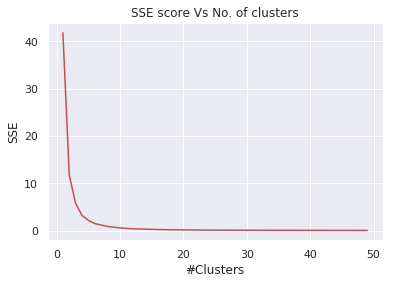

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.48576512455516013
Acc values :  [0.2846975088967972, 0.4377224199288256, 0.3718861209964413, 0.48576512455516013, 0.22953736654804271, 0.1903914590747331]
Acc values :  [[75, 28, 57], [75, 80, 91], [36, 116, 57], [66, 116, 91], [36, 80, 13], [66, 28, 13]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


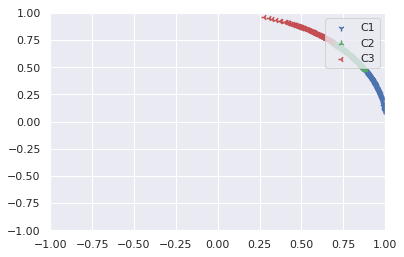

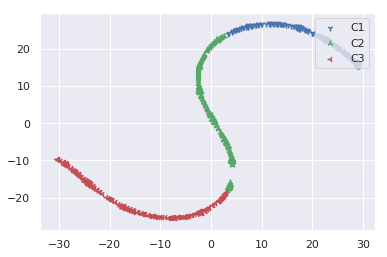

************************************************************
bin:2, thresh:5 
Clustering for 50 clusters ... 


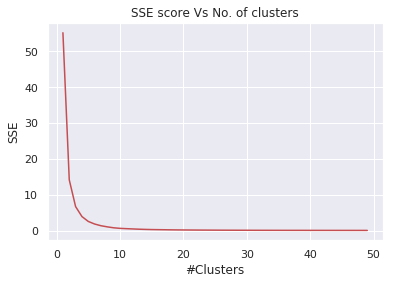

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.49110320284697506
Acc values :  [0.29359430604982206, 0.42704626334519574, 0.3807829181494662, 0.49110320284697506, 0.21530249110320285, 0.19217081850533807]
Acc values :  [[83, 26, 56], [83, 71, 86], [31, 127, 56], [63, 127, 86], [31, 71, 19], [63, 26, 19]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


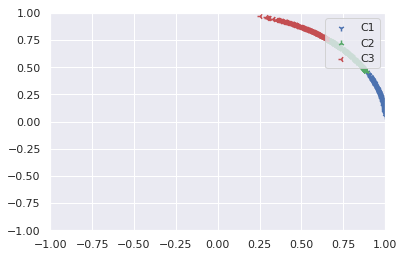

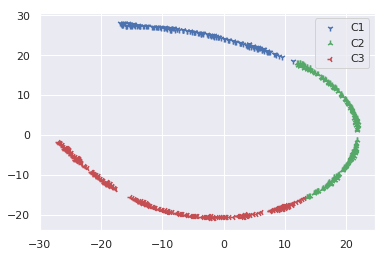

************************************************************
bin:2, thresh:8 
Clustering for 50 clusters ... 


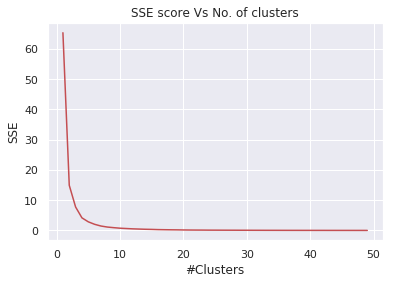

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.5142348754448398
Acc values :  [0.24555160142348753, 0.4750889679715303, 0.3469750889679715, 0.5142348754448398, 0.2402135231316726, 0.17793594306049823]
Acc values :  [[74, 27, 37], [74, 81, 112], [42, 116, 37], [61, 116, 112], [42, 81, 12], [61, 27, 12]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


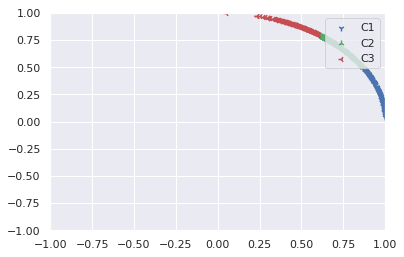

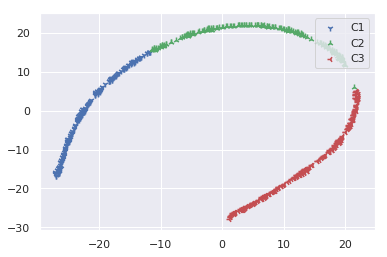

************************************************************
bin:2, thresh:11 
Clustering for 50 clusters ... 


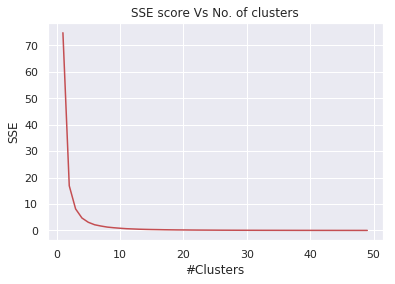

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.5124555160142349
Acc values :  [0.25622775800711745, 0.4555160142348754, 0.35587188612099646, 0.5124555160142349, 0.2313167259786477, 0.18861209964412812]
Acc values :  [[75, 31, 38], [75, 73, 108], [42, 120, 38], [60, 120, 108], [42, 73, 15], [60, 31, 15]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


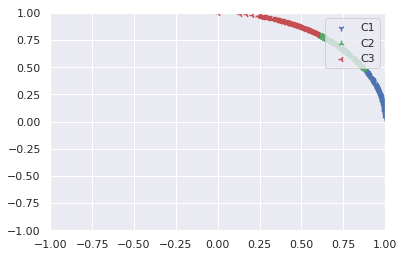

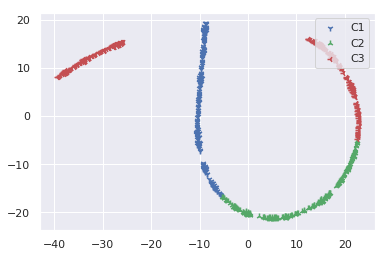

************************************************************
bin:2, thresh:14 
Clustering for 50 clusters ... 


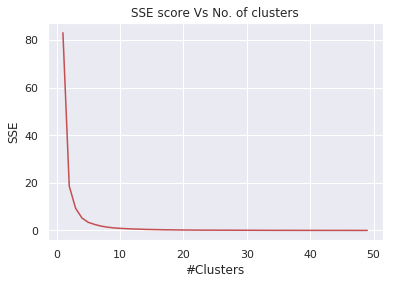

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.48576512455516013
Acc values :  [0.2597864768683274, 0.4412811387900356, 0.3291814946619217, 0.48576512455516013, 0.25444839857651247, 0.22953736654804271]
Acc values :  [[66, 46, 34], [66, 75, 107], [48, 103, 34], [63, 103, 107], [48, 75, 20], [63, 46, 20]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


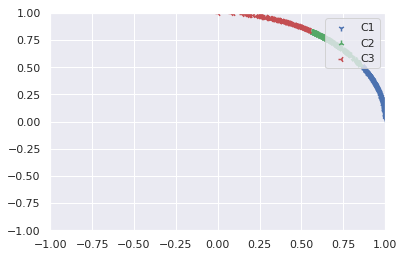

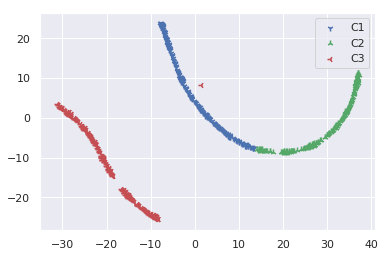

************************************************************
bin:2, thresh:17 
Clustering for 50 clusters ... 


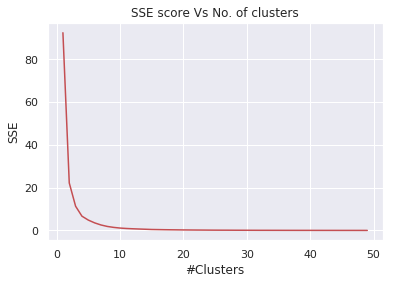

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.44661921708185054
Acc values :  [0.2491103202846975, 0.44661921708185054, 0.2580071174377224, 0.4128113879003559, 0.33807829181494664, 0.29537366548042704]
Acc values :  [[61, 53, 26], [61, 99, 91], [47, 72, 26], [69, 72, 91], [47, 99, 44], [69, 53, 44]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


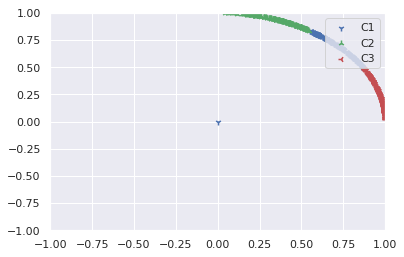

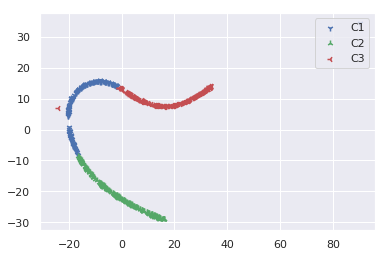

************************************************************
bin:2, thresh:20 
Clustering for 50 clusters ... 


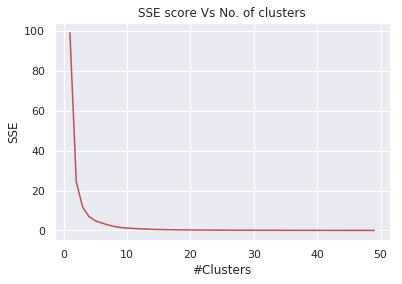

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.4181494661921708
Acc values :  [0.27402135231316727, 0.4181494661921708, 0.28113879003558717, 0.3914590747330961, 0.33451957295373663, 0.30071174377224197]
Acc values :  [[60, 57, 37], [60, 95, 80], [49, 72, 37], [68, 72, 80], [49, 95, 44], [68, 57, 44]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


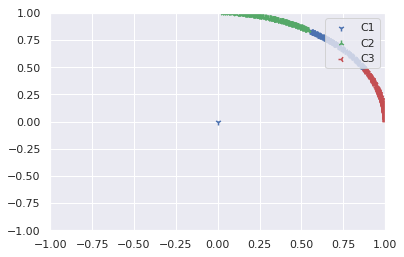

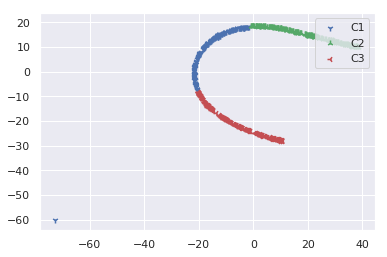

************************************************************
bin:2, thresh:23 
Clustering for 50 clusters ... 


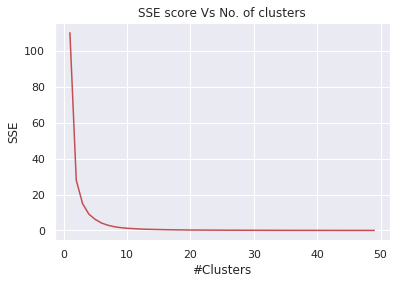

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.37722419928825623
Acc values :  [0.3736654804270463, 0.3202846975088968, 0.37722419928825623, 0.33451957295373663, 0.2918149466192171, 0.302491103202847]
Acc values :  [[78, 68, 64], [78, 59, 43], [51, 97, 64], [48, 97, 43], [51, 59, 54], [48, 68, 54]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


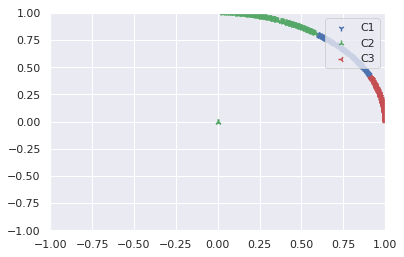

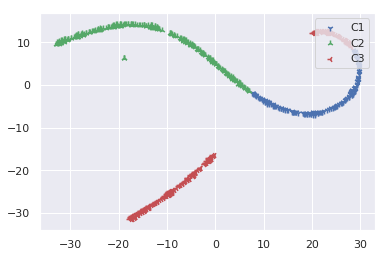

************************************************************
bin:2, thresh:26 
Clustering for 50 clusters ... 


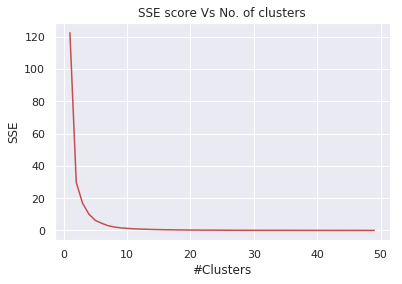

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.35231316725978645
Acc values :  [0.35231316725978645, 0.3096085409252669, 0.34341637010676157, 0.3096085409252669, 0.33807829181494664, 0.3469750889679715]
Acc values :  [[45, 100, 53], [45, 65, 64], [81, 59, 53], [51, 59, 64], [81, 65, 44], [51, 100, 44]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


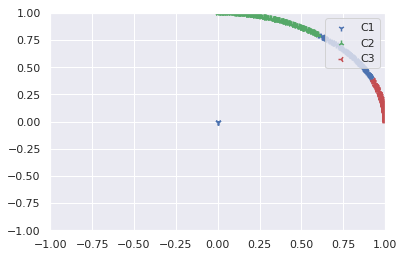

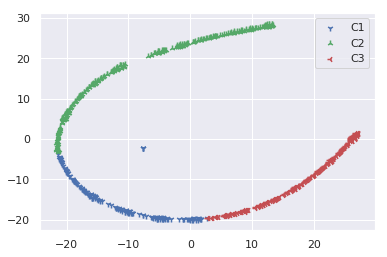

************************************************************
bin:2, thresh:29 
Clustering for 50 clusters ... 


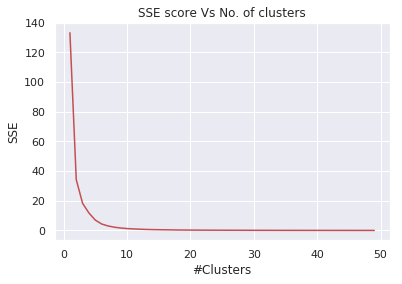

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.38434163701067614
Acc values :  [0.33451957295373663, 0.38434163701067614, 0.28825622775800713, 0.304270462633452, 0.3612099644128114, 0.3274021352313167]
Acc values :  [[57, 79, 52], [57, 96, 63], [61, 49, 52], [59, 49, 63], [61, 96, 46], [59, 79, 46]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


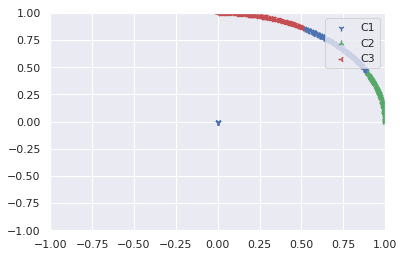

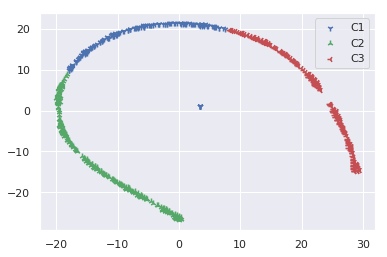

************************************************************
bin:4, thresh:2 
Clustering for 50 clusters ... 


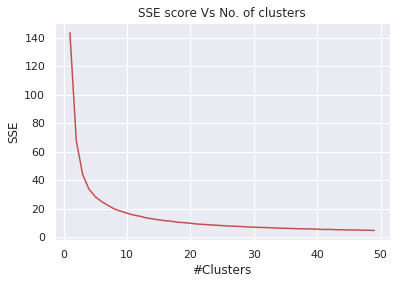

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.7935943060498221
Acc values :  [0.21708185053380782, 0.06583629893238434, 0.7935943060498221, 0.4679715302491103, 0.31494661921708184, 0.14056939501779359]
Acc values :  [[1, 4, 117], [1, 20, 16], [129, 200, 117], [47, 200, 16], [129, 20, 28], [47, 4, 28]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


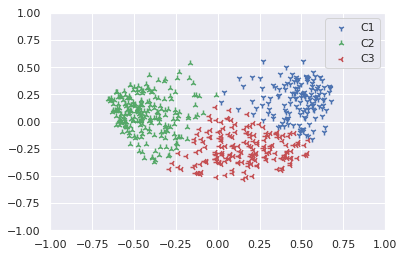

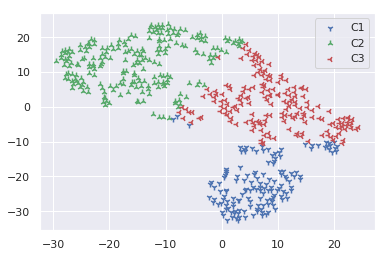

************************************************************
bin:4, thresh:5 
Clustering for 50 clusters ... 


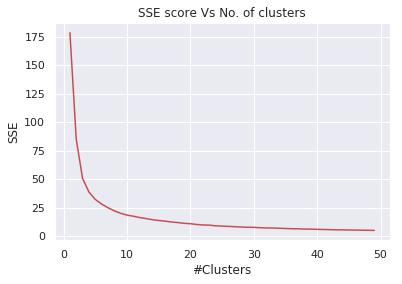

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.8202846975088968
Acc values :  [0.8202846975088968, 0.3202846975088968, 0.2206405693950178, 0.12633451957295375, 0.05338078291814947, 0.45907473309608543]
Acc values :  [[138, 205, 118], [138, 14, 28], [1, 5, 118], [38, 5, 28], [1, 14, 15], [38, 205, 15]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


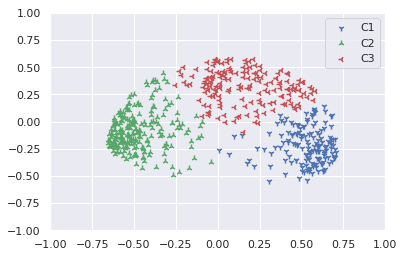

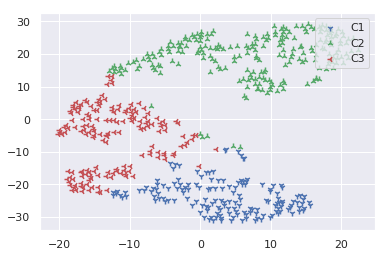

************************************************************
bin:4, thresh:8 
Clustering for 50 clusters ... 


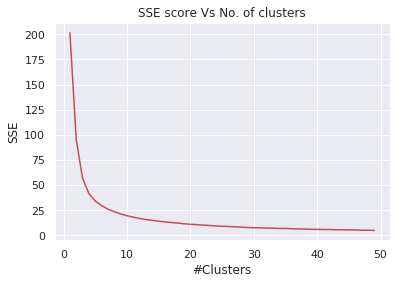

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.8238434163701067
Acc values :  [0.22597864768683273, 0.060498220640569395, 0.8238434163701067, 0.4412811387900356, 0.33274021352313166, 0.11565836298932385]
Acc values :  [[1, 4, 122], [1, 20, 13], [141, 200, 122], [35, 200, 13], [141, 20, 26], [35, 4, 26]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


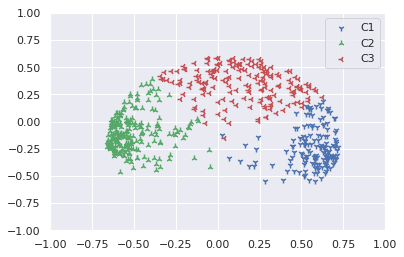

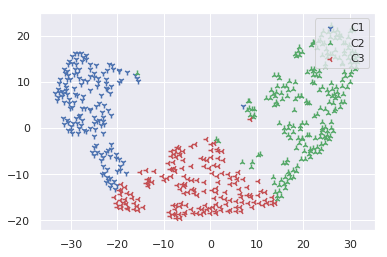

************************************************************
bin:4, thresh:11 
Clustering for 50 clusters ... 


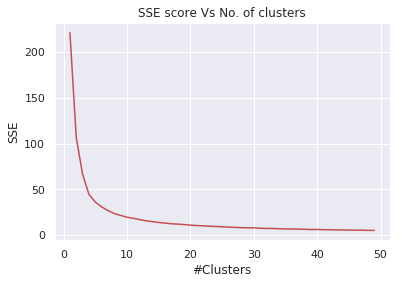

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.8238434163701067
Acc values :  [0.05693950177935943, 0.2188612099644128, 0.4412811387900356, 0.8238434163701067, 0.11921708185053381, 0.3398576512455516]
Acc values :  [[1, 18, 13], [1, 4, 118], [33, 202, 13], [143, 202, 118], [33, 4, 30], [143, 18, 30]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


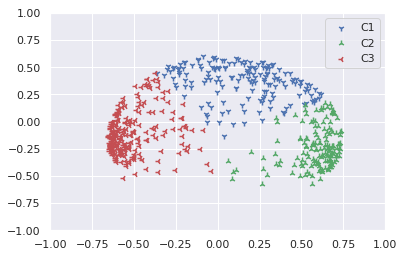

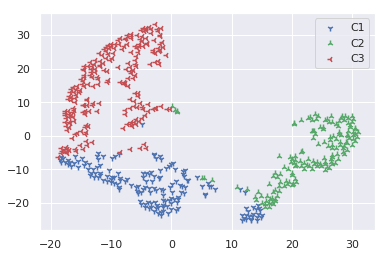

************************************************************
bin:4, thresh:14 
Clustering for 50 clusters ... 


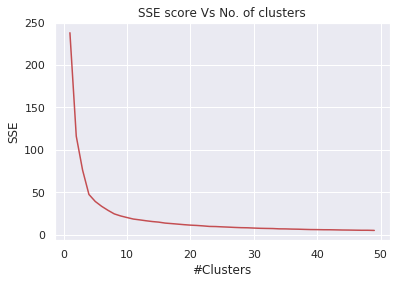

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.7740213523131673
Acc values :  [0.18861209964412812, 0.14590747330960854, 0.7740213523131673, 0.39501779359430605, 0.41637010676156583, 0.0800711743772242]
Acc values :  [[2, 6, 98], [2, 44, 36], [163, 174, 98], [12, 174, 36], [163, 44, 27], [12, 6, 27]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


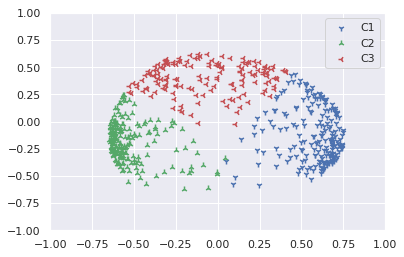

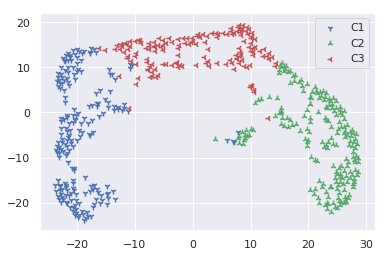

************************************************************
bin:4, thresh:17 
Clustering for 50 clusters ... 


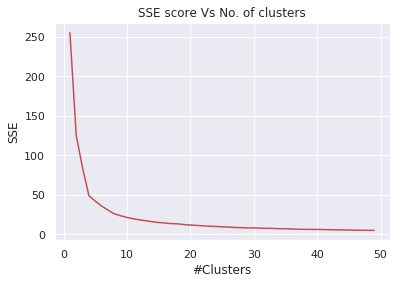

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.6494661921708185
Acc values :  [0.26334519572953735, 0.12099644128113879, 0.40391459074733094, 0.6494661921708185, 0.08718861209964412, 0.4750889679715303]
Acc values :  [[6, 67, 75], [6, 10, 52], [5, 147, 75], [166, 147, 52], [5, 10, 34], [166, 67, 34]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


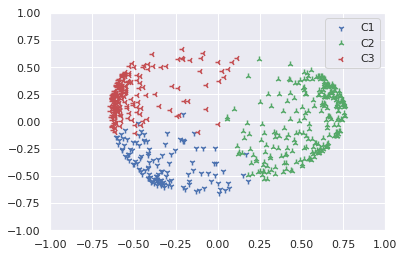

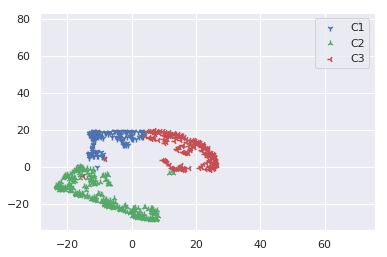

************************************************************
bin:4, thresh:20 
Clustering for 50 clusters ... 


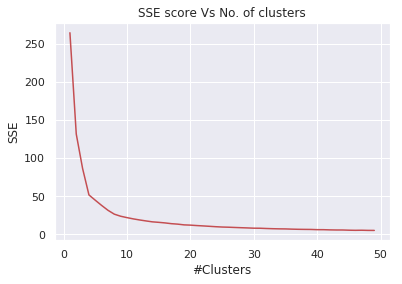

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.6387900355871886
Acc values :  [0.11743772241992882, 0.2491103202846975, 0.6387900355871886, 0.3914590747330961, 0.49110320284697506, 0.11209964412811388]
Acc values :  [[5, 10, 51], [5, 69, 66], [163, 145, 51], [9, 145, 66], [163, 69, 44], [9, 10, 44]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


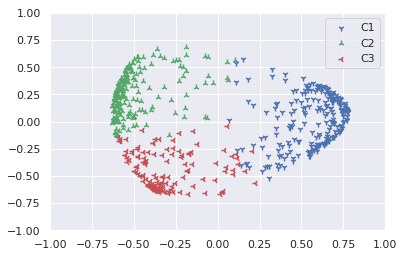

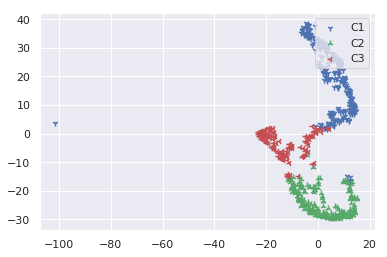

************************************************************
bin:4, thresh:23 
Clustering for 50 clusters ... 


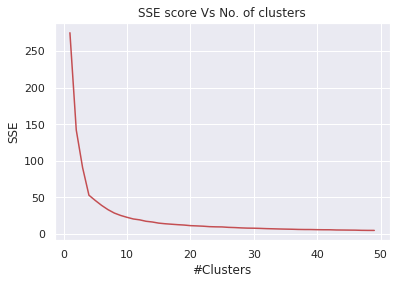

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.608540925266904
Acc values :  [0.1103202846975089, 0.36298932384341637, 0.5142348754448398, 0.28113879003558717, 0.608540925266904, 0.12277580071174377]
Acc values :  [[8, 12, 42], [8, 128, 68], [163, 84, 42], [6, 84, 68], [163, 128, 51], [6, 12, 51]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


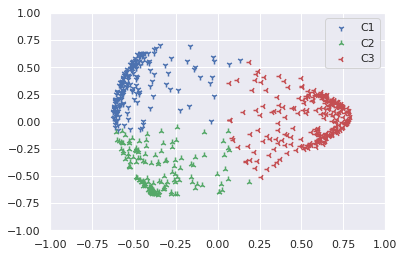

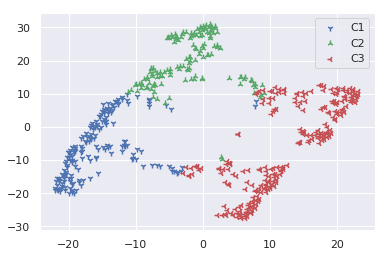

************************************************************
bin:4, thresh:26 
Clustering for 50 clusters ... 


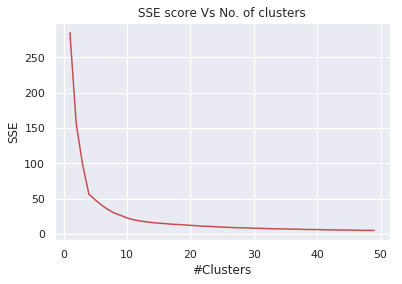

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.5729537366548043
Acc values :  [0.1298932384341637, 0.298932384341637, 0.5729537366548043, 0.3113879003558719, 0.5587188612099644, 0.12811387900355872]
Acc values :  [[7, 14, 52], [7, 102, 59], [162, 108, 52], [8, 108, 59], [162, 102, 50], [8, 14, 50]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


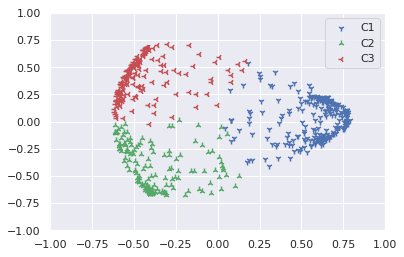

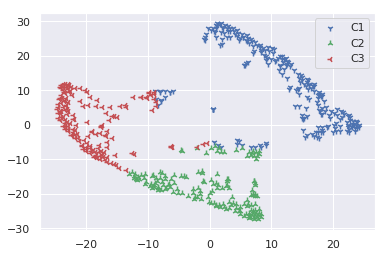

************************************************************
bin:4, thresh:29 
Clustering for 50 clusters ... 


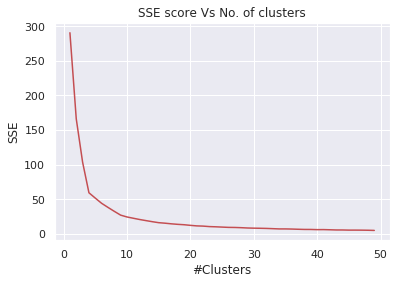

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.5854092526690391
Acc values :  [0.13523131672597866, 0.302491103202847, 0.5854092526690391, 0.3291814946619217, 0.5355871886120996, 0.11209964412811388]
Acc values :  [[8, 13, 55], [8, 98, 64], [161, 113, 55], [8, 113, 64], [161, 98, 42], [8, 13, 42]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


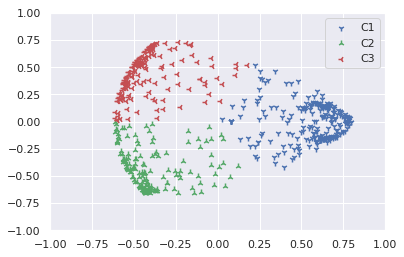

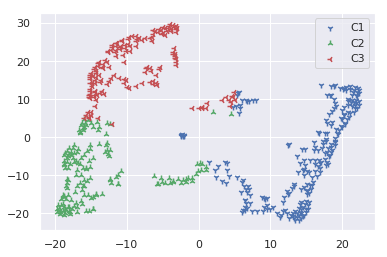

************************************************************
bin:6, thresh:2 
Clustering for 50 clusters ... 


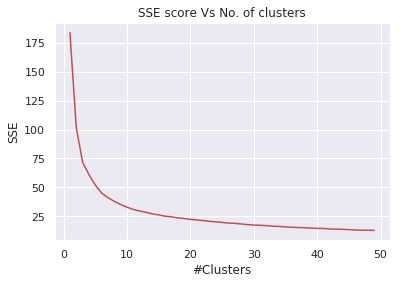

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.8612099644128114
Acc values :  [0.4377224199288256, 0.08540925266903915, 0.05338078291814947, 0.3113879003558719, 0.2508896797153025, 0.8612099644128114]
Acc values :  [[30, 204, 12], [30, 4, 14], [2, 16, 12], [145, 16, 14], [2, 4, 135], [145, 204, 135]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


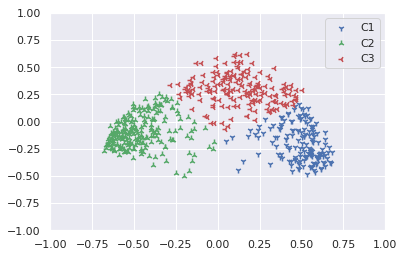

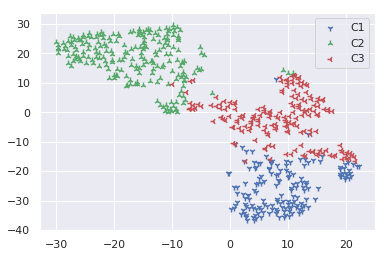

************************************************************
bin:6, thresh:5 
Clustering for 50 clusters ... 


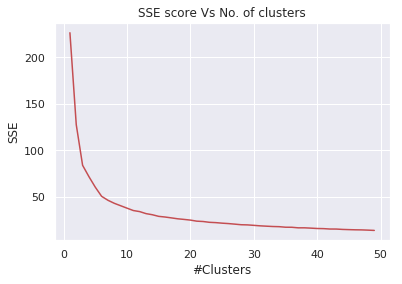

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.8754448398576512
Acc values :  [0.23309608540925267, 0.05871886120996441, 0.8754448398576512, 0.43238434163701067, 0.33451957295373663, 0.06583629893238434]
Acc values :  [[1, 4, 126], [1, 13, 19], [159, 207, 126], [17, 207, 19], [159, 13, 16], [17, 4, 16]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


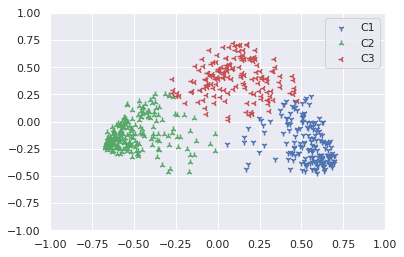

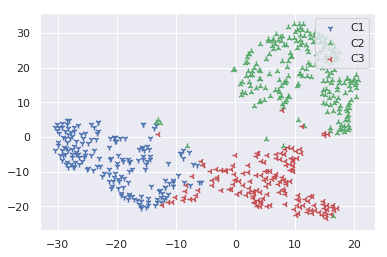

************************************************************
bin:6, thresh:8 
Clustering for 50 clusters ... 


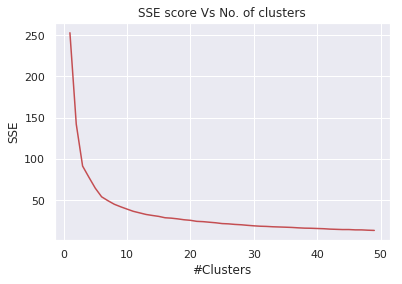

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.8754448398576512
Acc values :  [0.22597864768683273, 0.05338078291814947, 0.8754448398576512, 0.4412811387900356, 0.33274021352313166, 0.0711743772241993]
Acc values :  [[1, 3, 123], [1, 10, 19], [158, 211, 123], [18, 211, 19], [158, 10, 19], [18, 3, 19]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


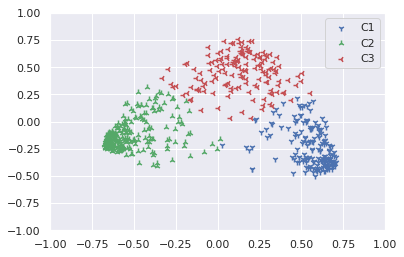

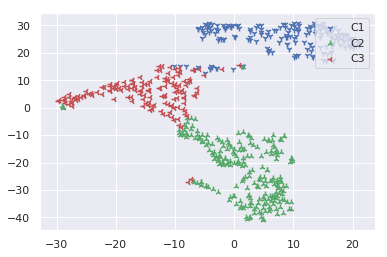

************************************************************
bin:6, thresh:11 
Clustering for 50 clusters ... 


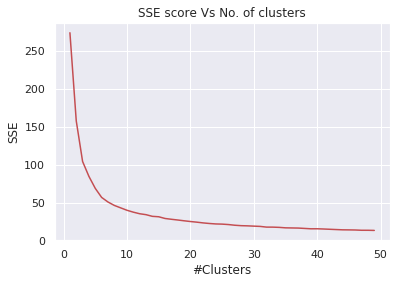

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.8772241992882562
Acc values :  [0.22953736654804271, 0.051601423487544484, 0.8772241992882562, 0.4359430604982206, 0.33451957295373663, 0.0711743772241993]
Acc values :  [[2, 3, 124], [2, 10, 17], [158, 211, 124], [17, 211, 17], [158, 10, 20], [17, 3, 20]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


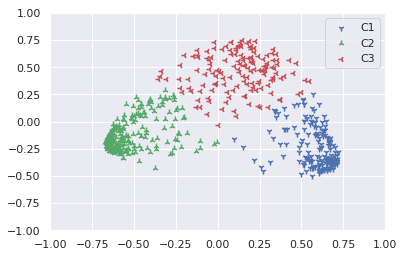

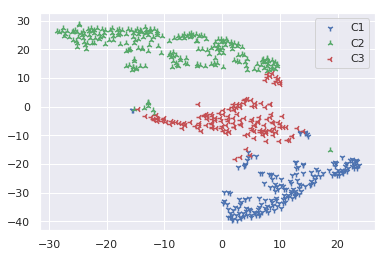

************************************************************
bin:6, thresh:14 
Clustering for 50 clusters ... 


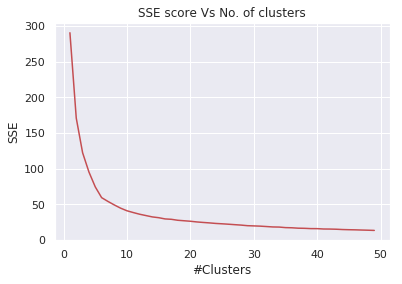

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.8523131672597865
Acc values :  [0.8523131672597865, 0.3416370106761566, 0.2313167259786477, 0.08362989323843416, 0.06405693950177936, 0.42704626334519574]
Acc values :  [[155, 203, 121], [155, 15, 22], [3, 6, 121], [19, 6, 22], [3, 15, 18], [19, 203, 18]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


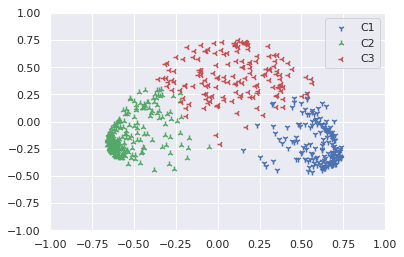

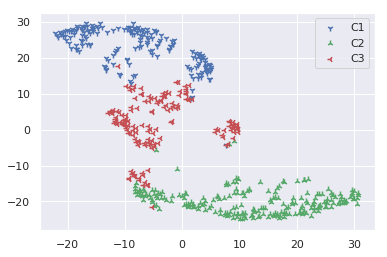

************************************************************
bin:6, thresh:17 
Clustering for 50 clusters ... 


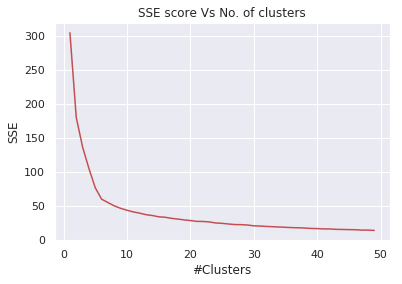

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.791814946619217
Acc values :  [0.16725978647686832, 0.09252669039145907, 0.791814946619217, 0.4626334519572954, 0.3701067615658363, 0.11565836298932385]
Acc values :  [[4, 7, 83], [4, 11, 37], [156, 206, 83], [17, 206, 37], [156, 11, 41], [17, 7, 41]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


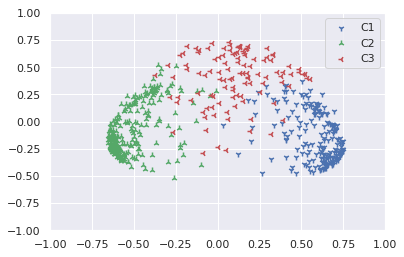

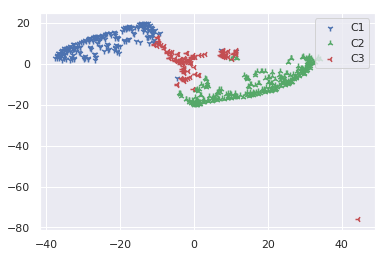

************************************************************
bin:6, thresh:20 
Clustering for 50 clusters ... 


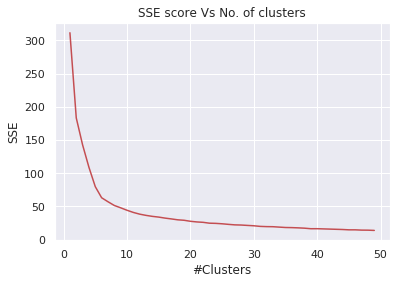

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.699288256227758
Acc values :  [0.699288256227758, 0.4555160142348754, 0.17437722419928825, 0.08540925266903915, 0.21530249110320285, 0.3701067615658363]
Acc values :  [[162, 148, 83], [162, 66, 28], [5, 10, 83], [10, 10, 28], [5, 66, 50], [10, 148, 50]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


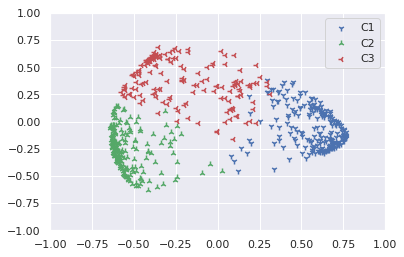

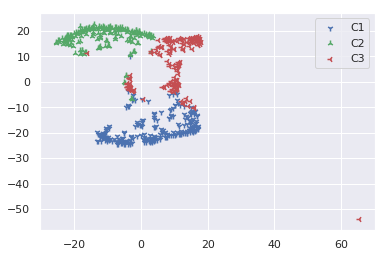

************************************************************
bin:6, thresh:23 
Clustering for 50 clusters ... 


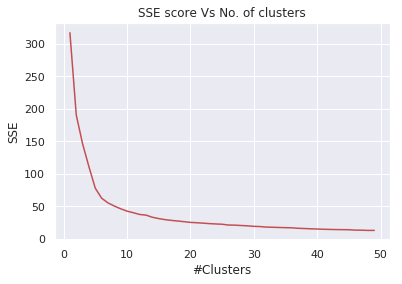

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.6494661921708185
Acc values :  [0.3416370106761566, 0.09252669039145907, 0.2580071174377224, 0.50355871886121, 0.15480427046263345, 0.6494661921708185]
Acc values :  [[7, 130, 55], [7, 10, 35], [6, 84, 55], [164, 84, 35], [6, 10, 71], [164, 130, 71]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


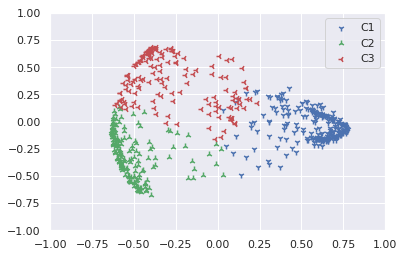

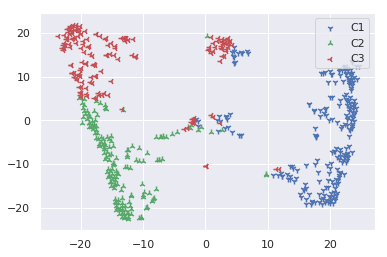

************************************************************
bin:6, thresh:26 
Clustering for 50 clusters ... 


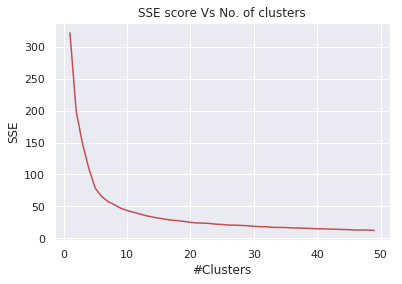

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.5658362989323843
Acc values :  [0.11743772241992882, 0.3309608540925267, 0.5658362989323843, 0.33274021352313166, 0.5498220640569395, 0.10320284697508897]
Acc values :  [[4, 14, 48], [4, 106, 76], [166, 104, 48], [7, 104, 76], [166, 106, 37], [7, 14, 37]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


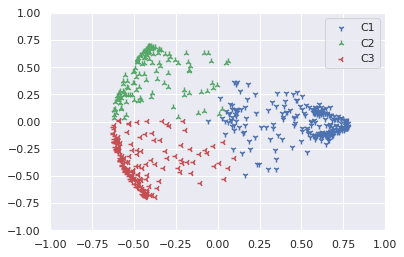

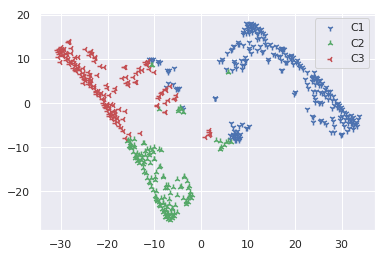

************************************************************
bin:6, thresh:29 
Clustering for 50 clusters ... 


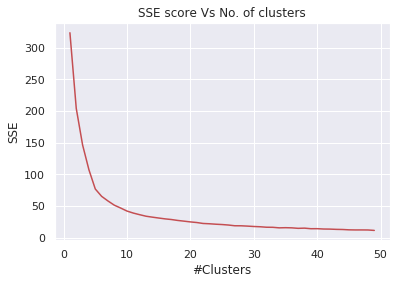

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.5854092526690391
Acc values :  [0.13523131672597866, 0.30782918149466193, 0.5854092526690391, 0.33451957295373663, 0.5302491103202847, 0.10676156583629894]
Acc values :  [[5, 16, 55], [5, 98, 70], [164, 110, 55], [8, 110, 70], [164, 98, 36], [8, 16, 36]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


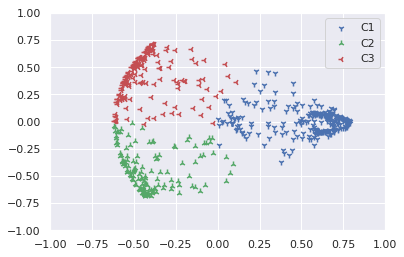

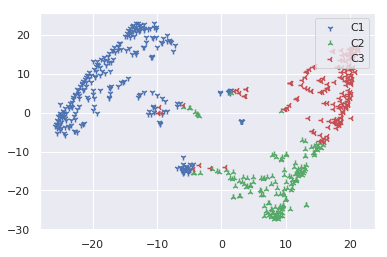

************************************************************
bin:8, thresh:2 
Clustering for 50 clusters ... 


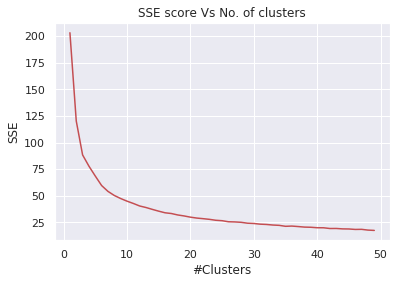

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.8505338078291815
Acc values :  [0.8505338078291815, 0.3220640569395018, 0.23487544483985764, 0.07473309608540925, 0.07473309608540925, 0.4430604982206406]
Acc values :  [[151, 202, 125], [151, 17, 13], [2, 5, 125], [24, 5, 13], [2, 17, 23], [24, 202, 23]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


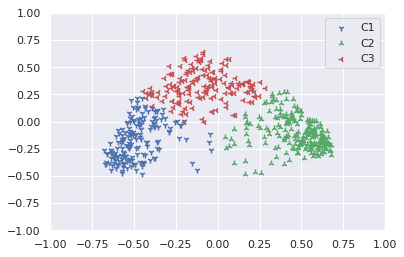

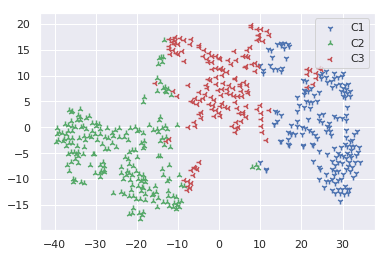

************************************************************
bin:8, thresh:5 
Clustering for 50 clusters ... 


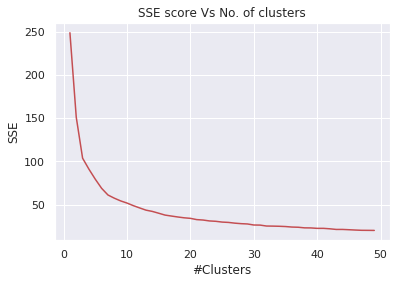

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.8594306049822064
Acc values :  [0.22953736654804271, 0.0711743772241993, 0.8594306049822064, 0.4412811387900356, 0.3291814946619217, 0.0693950177935943]
Acc values :  [[1, 4, 124], [1, 16, 23], [155, 204, 124], [21, 204, 23], [155, 16, 14], [21, 4, 14]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


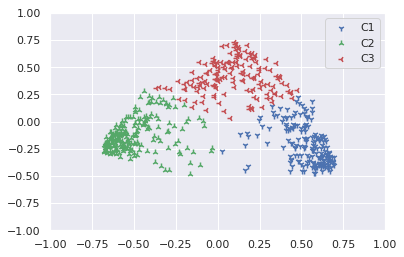

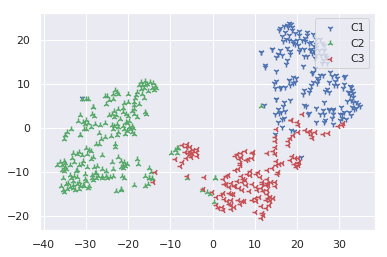

************************************************************
bin:8, thresh:8 
Clustering for 50 clusters ... 


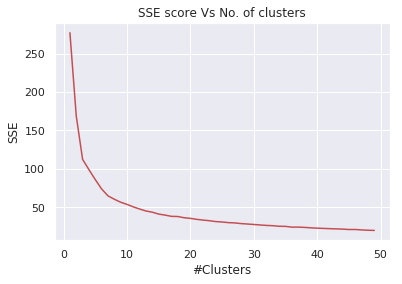

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.8540925266903915
Acc values :  [0.22597864768683273, 0.06405693950177936, 0.8540925266903915, 0.4412811387900356, 0.33274021352313166, 0.08185053380782918]
Acc values :  [[1, 3, 123], [1, 16, 19], [152, 205, 123], [24, 205, 19], [152, 16, 19], [24, 3, 19]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


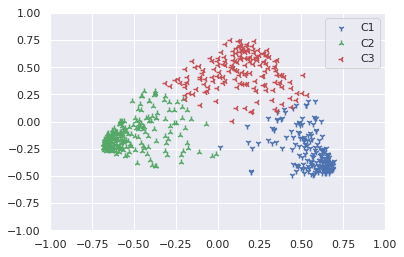

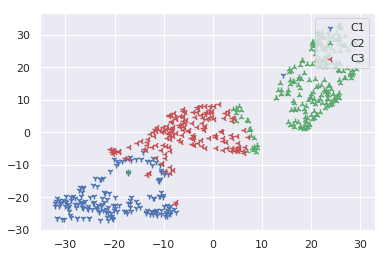

************************************************************
bin:8, thresh:11 
Clustering for 50 clusters ... 


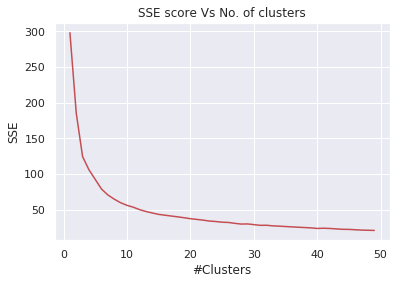

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.8434163701067615
Acc values :  [0.23487544483985764, 0.06405693950177936, 0.8434163701067615, 0.44483985765124556, 0.3202846975088968, 0.09252669039145907]
Acc values :  [[2, 3, 127], [2, 18, 16], [144, 203, 127], [31, 203, 16], [144, 18, 18], [31, 3, 18]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


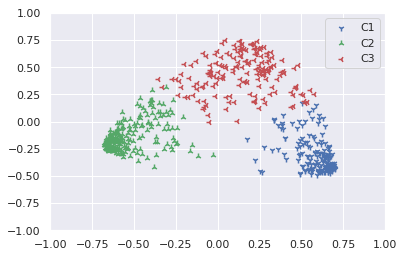

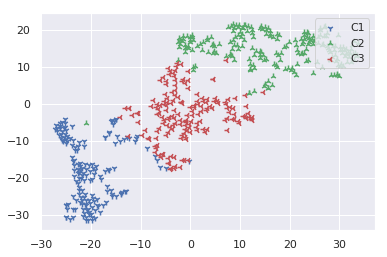

************************************************************
bin:8, thresh:14 
Clustering for 50 clusters ... 


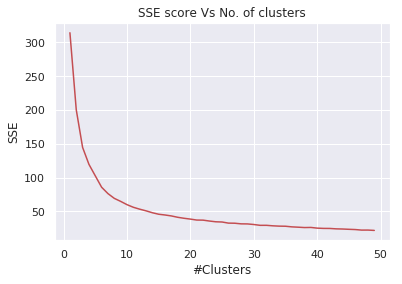

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.8309608540925267
Acc values :  [0.10142348754448399, 0.44483985765124556, 0.32562277580071175, 0.06761565836298933, 0.8309608540925267, 0.22953736654804271]
Acc values :  [[30, 5, 22], [30, 202, 18], [144, 17, 22], [3, 17, 18], [144, 202, 121], [3, 5, 121]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


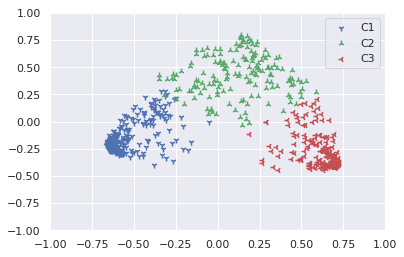

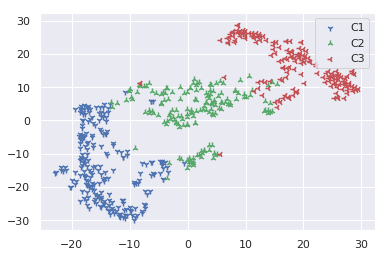

************************************************************
bin:8, thresh:17 
Clustering for 50 clusters ... 


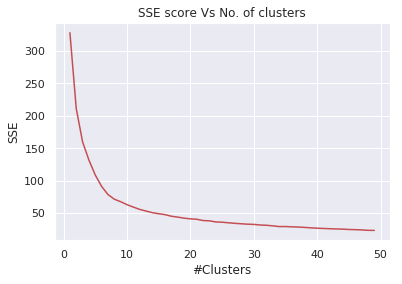

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.7740213523131673
Acc values :  [0.7740213523131673, 0.35231316725978645, 0.18861209964412812, 0.13345195729537365, 0.09252669039145907, 0.45907473309608543]
Acc values :  [[141, 198, 96], [141, 20, 37], [4, 6, 96], [32, 6, 37], [4, 20, 28], [32, 198, 28]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


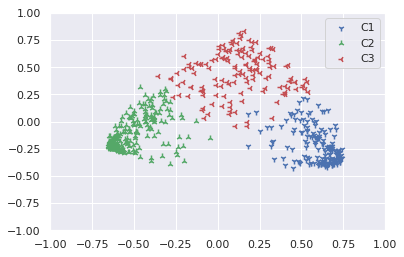

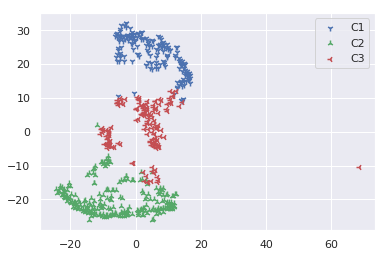

************************************************************
bin:8, thresh:20 
Clustering for 50 clusters ... 


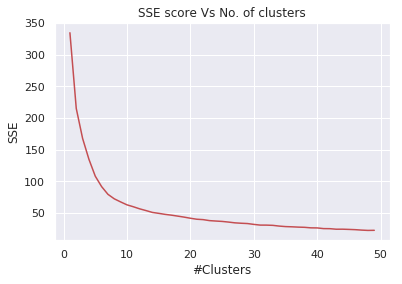

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.7277580071174378
Acc values :  [0.7277580071174378, 0.3790035587188612, 0.1494661921708185, 0.1583629893238434, 0.11387900355871886, 0.47153024911032027]
Acc values :  [[140, 198, 71], [140, 20, 53], [7, 6, 71], [30, 6, 53], [7, 20, 37], [30, 198, 37]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


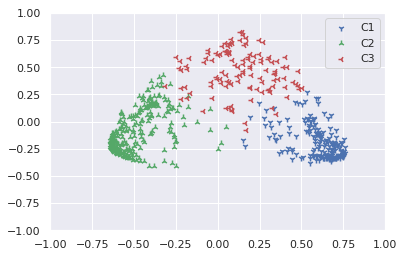

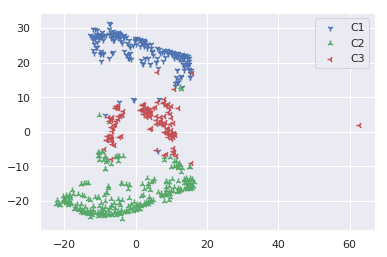

************************************************************
bin:8, thresh:23 
Clustering for 50 clusters ... 


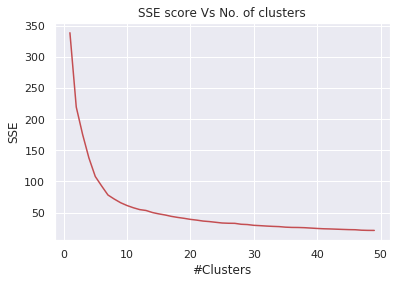

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.7046263345195729
Acc values :  [0.1298932384341637, 0.12277580071174377, 0.7046263345195729, 0.4679715302491103, 0.40213523131672596, 0.17259786476868327]
Acc values :  [[7, 7, 59], [7, 22, 40], [142, 195, 59], [28, 195, 40], [142, 22, 62], [28, 7, 62]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


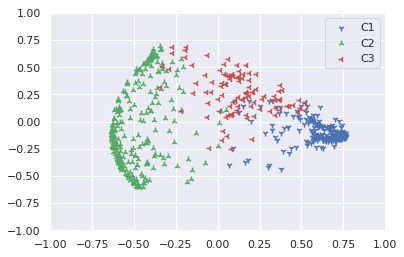

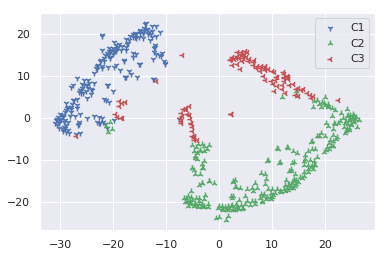

************************************************************
bin:8, thresh:26 
Clustering for 50 clusters ... 


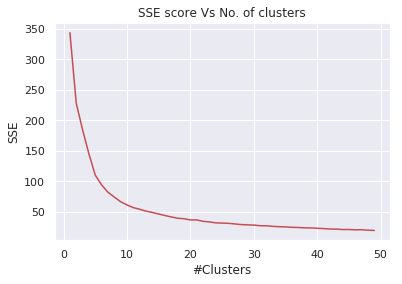

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.5587188612099644
Acc values :  [0.5355871886120996, 0.5587188612099644, 0.09608540925266904, 0.12455516014234876, 0.3398576512455516, 0.34519572953736655]
Acc values :  [[169, 104, 28], [169, 99, 46], [5, 21, 28], [3, 21, 46], [5, 99, 87], [3, 104, 87]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


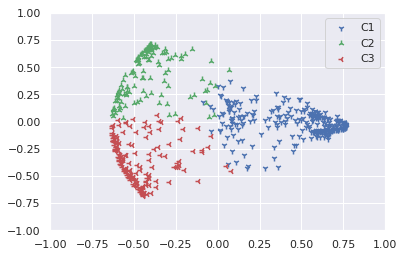

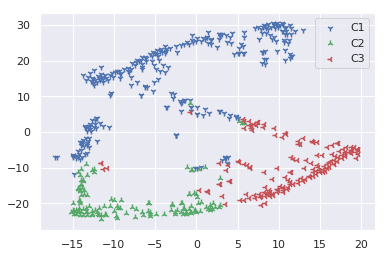

************************************************************
bin:8, thresh:29 
Clustering for 50 clusters ... 


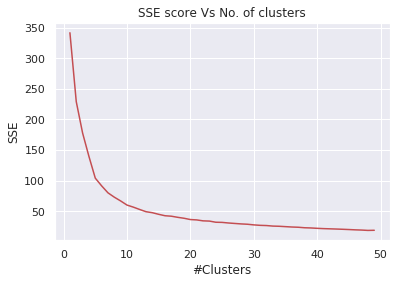

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.5711743772241993
Acc values :  [0.13523131672597866, 0.3274021352313167, 0.5711743772241993, 0.35231316725978645, 0.5124555160142349, 0.10142348754448399]
Acc values :  [[4, 23, 49], [4, 95, 85], [166, 106, 49], [7, 106, 85], [166, 95, 27], [7, 23, 27]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


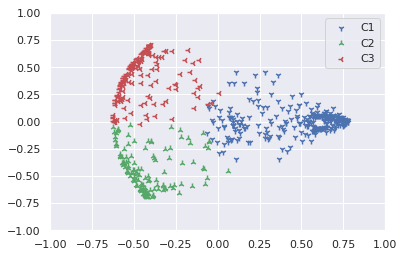

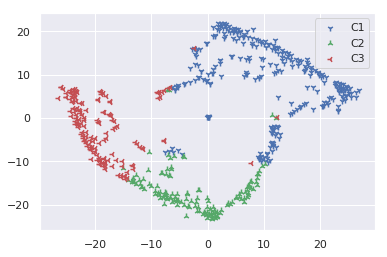

************************************************************
bin:10, thresh:2 
Clustering for 50 clusters ... 


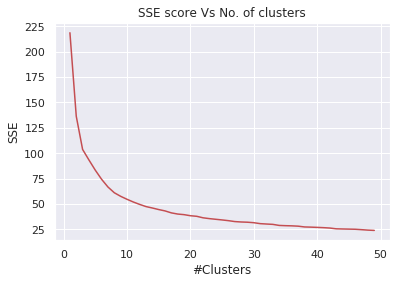

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.8434163701067615
Acc values :  [0.8434163701067615, 0.3220640569395018, 0.22953736654804271, 0.07829181494661921, 0.07829181494661921, 0.4483985765124555]
Acc values :  [[150, 202, 122], [150, 17, 14], [2, 5, 122], [25, 5, 14], [2, 17, 25], [25, 202, 25]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


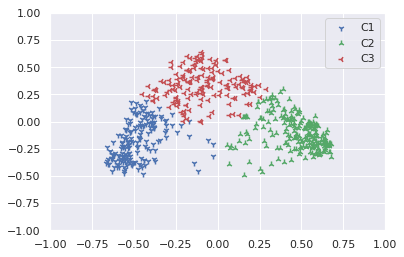

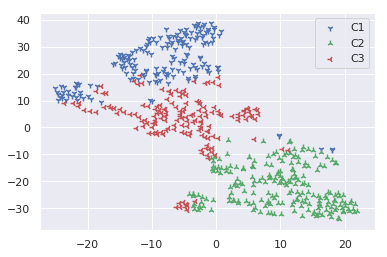

************************************************************
bin:10, thresh:5 
Clustering for 50 clusters ... 


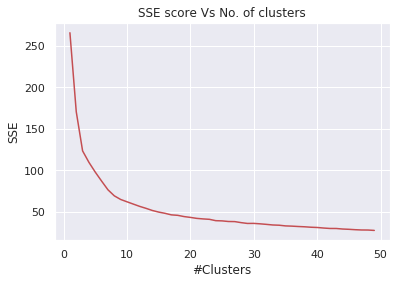

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.8558718861209964
Acc values :  [0.8558718861209964, 0.32562277580071175, 0.2277580071174377, 0.0693950177935943, 0.07473309608540925, 0.44661921708185054]
Acc values :  [[153, 204, 124], [153, 17, 13], [1, 3, 124], [23, 3, 13], [1, 17, 24], [23, 204, 24]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


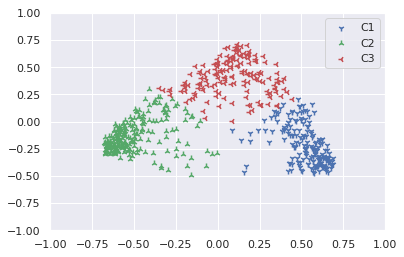

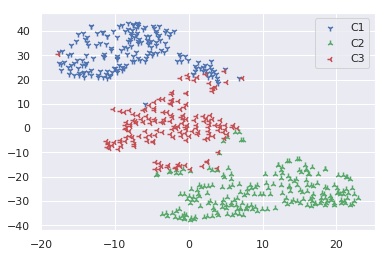

************************************************************
bin:10, thresh:8 
Clustering for 50 clusters ... 


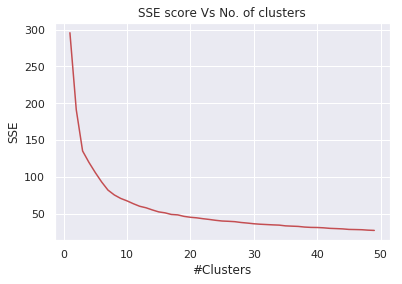

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.8434163701067615
Acc values :  [0.08362989323843416, 0.4359430604982206, 0.33629893238434166, 0.07295373665480427, 0.8434163701067615, 0.2277580071174377]
Acc values :  [[25, 3, 19], [25, 201, 19], [150, 20, 19], [2, 20, 19], [150, 201, 123], [2, 3, 123]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


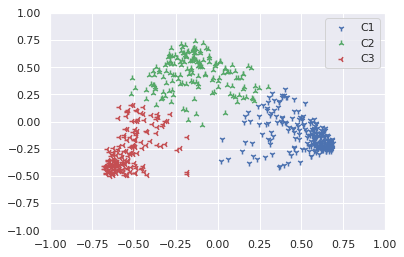

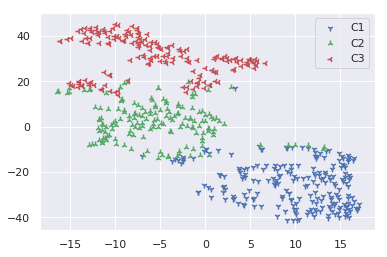

************************************************************
bin:10, thresh:11 
Clustering for 50 clusters ... 


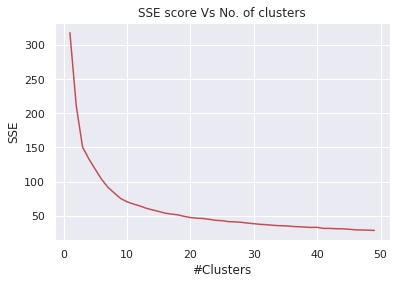

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.8309608540925267
Acc values :  [0.10854092526690391, 0.4501779359430605, 0.31316725978647686, 0.060498220640569395, 0.8309608540925267, 0.23665480427046262]
Acc values :  [[38, 3, 20], [38, 202, 13], [137, 19, 20], [2, 19, 13], [137, 202, 128], [2, 3, 128]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


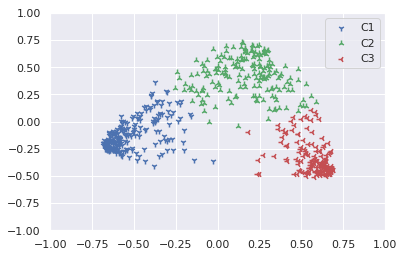

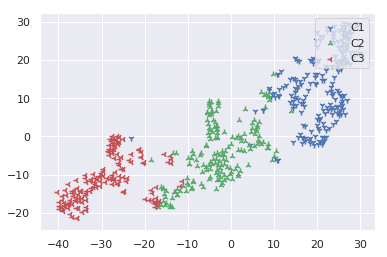

************************************************************
bin:10, thresh:14 
Clustering for 50 clusters ... 


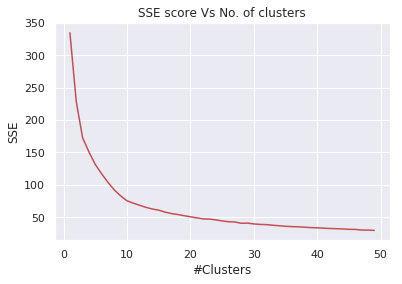

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.8042704626334519
Acc values :  [0.07829181494661921, 0.23843416370106763, 0.4377224199288256, 0.8042704626334519, 0.11743772241992882, 0.3238434163701068]
Acc values :  [[3, 28, 13], [3, 4, 127], [41, 192, 13], [133, 192, 127], [41, 4, 21], [133, 28, 21]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


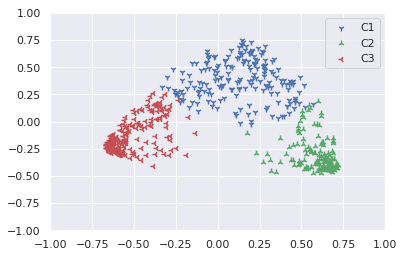

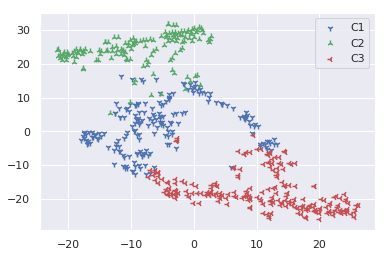

************************************************************
bin:10, thresh:17 
Clustering for 50 clusters ... 


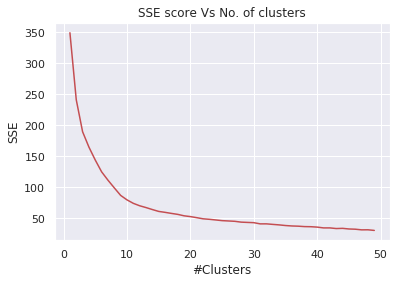

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.7419928825622776
Acc values :  [0.7419928825622776, 0.35765124555160144, 0.19217081850533807, 0.1512455516014235, 0.10676156583629894, 0.4501779359430605]
Acc values :  [[132, 187, 98], [132, 31, 38], [4, 6, 98], [41, 6, 38], [4, 31, 25], [41, 187, 25]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


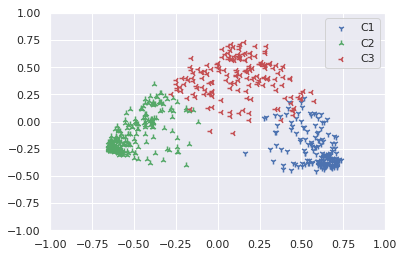

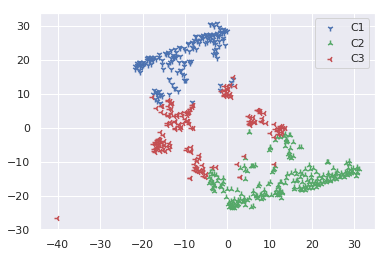

************************************************************
bin:10, thresh:20 
Clustering for 50 clusters ... 


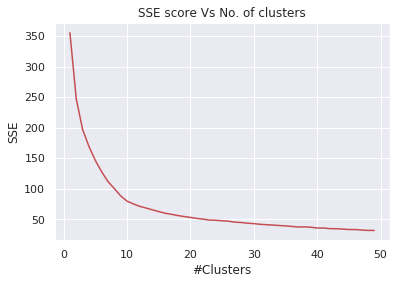

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.6868327402135231
Acc values :  [0.6868327402135231, 0.3861209964412811, 0.16548042704626334, 0.17259786476868327, 0.14056939501779359, 0.4483985765124555]
Acc values :  [[129, 177, 80], [129, 40, 48], [6, 7, 80], [42, 7, 48], [6, 40, 33], [42, 177, 33]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


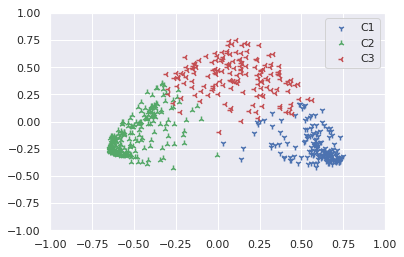

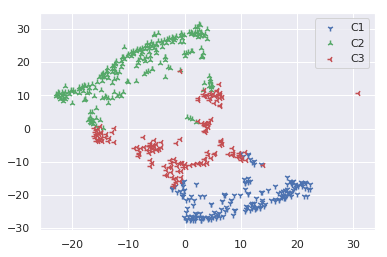

************************************************************
bin:10, thresh:23 
Clustering for 50 clusters ... 


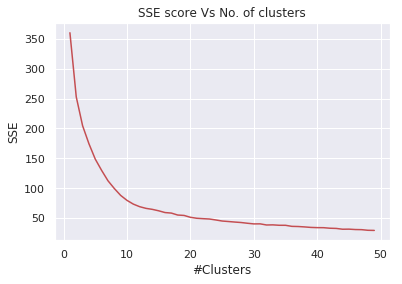

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.6708185053380783
Acc values :  [0.6708185053380783, 0.4306049822064057, 0.1494661921708185, 0.17437722419928825, 0.15480427046263345, 0.4199288256227758]
Acc values :  [[137, 169, 71], [137, 48, 57], [6, 7, 71], [34, 7, 57], [6, 48, 33], [34, 169, 33]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


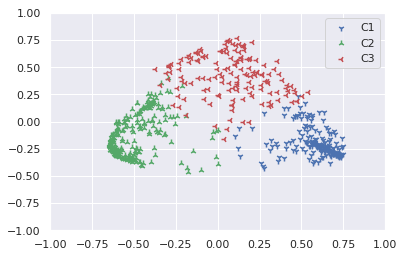

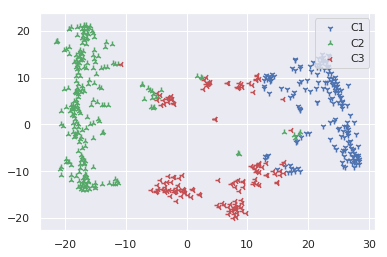

************************************************************
bin:10, thresh:26 
Clustering for 50 clusters ... 


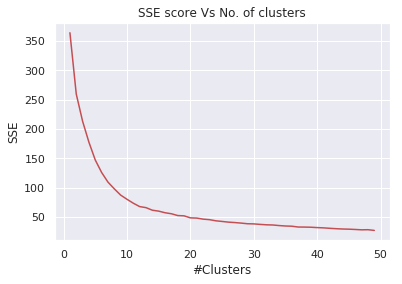

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.6298932384341637
Acc values :  [0.40391459074733094, 0.19395017793594305, 0.17615658362989323, 0.4608540925266904, 0.13523131672597866, 0.6298932384341637]
Acc values :  [[28, 160, 39], [28, 13, 68], [9, 51, 39], [140, 51, 68], [9, 13, 54], [140, 160, 54]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


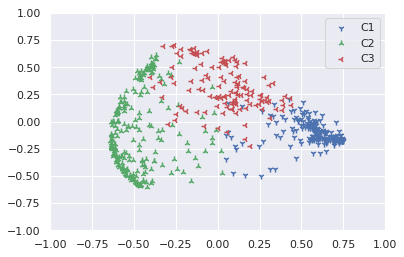

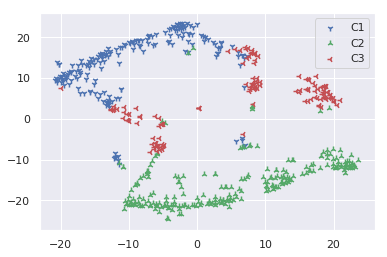

************************************************************
bin:10, thresh:29 
Clustering for 50 clusters ... 


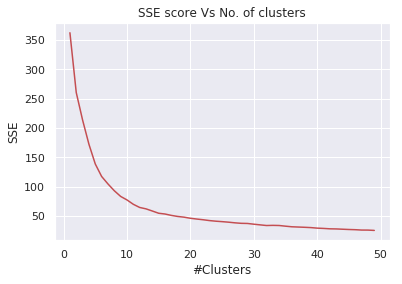

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.5800711743772242
Acc values :  [0.13523131672597866, 0.26512455516014233, 0.5800711743772242, 0.297153024911032, 0.5676156583629893, 0.15480427046263345]
Acc values :  [[12, 13, 51], [12, 94, 43], [158, 117, 51], [7, 117, 43], [158, 94, 67], [7, 13, 67]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


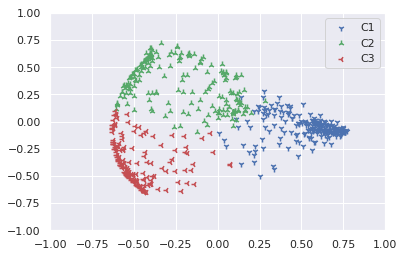

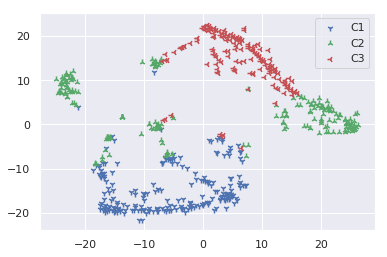

************************************************************
bin:12, thresh:2 
Clustering for 50 clusters ... 


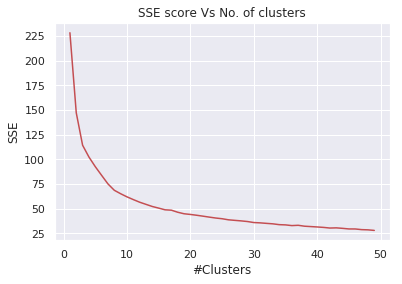

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.8451957295373665
Acc values :  [0.22953736654804271, 0.0800711743772242, 0.8451957295373665, 0.4430604982206406, 0.3274021352313167, 0.07473309608540925]
Acc values :  [[2, 4, 123], [2, 19, 24], [151, 201, 123], [24, 201, 24], [151, 19, 14], [24, 4, 14]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


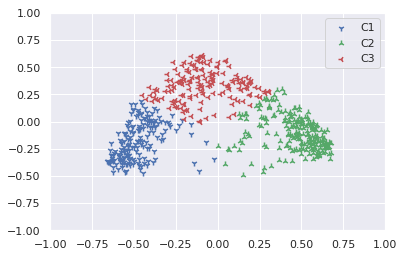

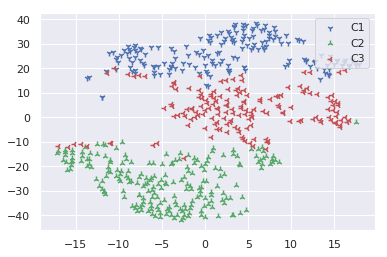

************************************************************
bin:12, thresh:5 
Clustering for 50 clusters ... 


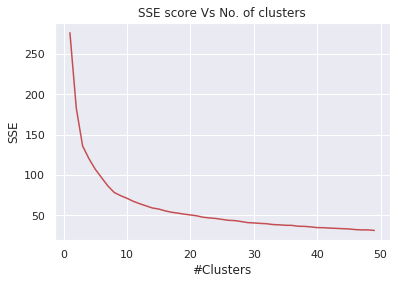

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.8523131672597865
Acc values :  [0.07829181494661921, 0.22597864768683273, 0.44661921708185054, 0.8523131672597865, 0.0693950177935943, 0.3274021352313167]
Acc values :  [[1, 18, 25], [1, 3, 123], [23, 203, 25], [153, 203, 123], [23, 3, 13], [153, 18, 13]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


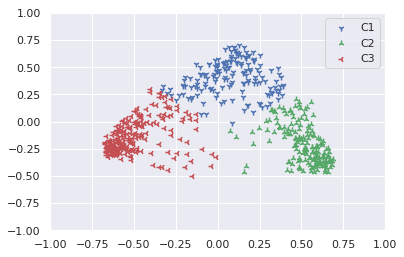

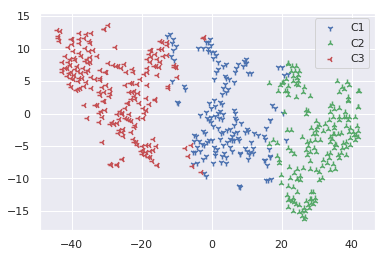

************************************************************
bin:12, thresh:8 
Clustering for 50 clusters ... 


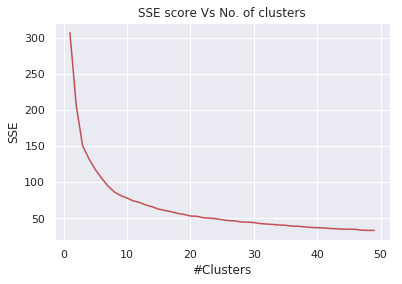

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.8362989323843416
Acc values :  [0.09074733096085409, 0.4395017793594306, 0.3309608540925267, 0.07295373665480427, 0.8362989323843416, 0.22953736654804271]
Acc values :  [[28, 4, 19], [28, 200, 19], [147, 20, 19], [2, 20, 19], [147, 200, 123], [2, 4, 123]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


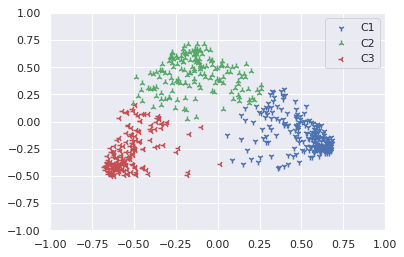

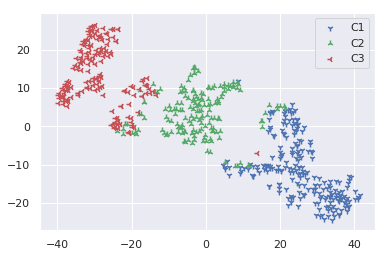

************************************************************
bin:12, thresh:11 
Clustering for 50 clusters ... 


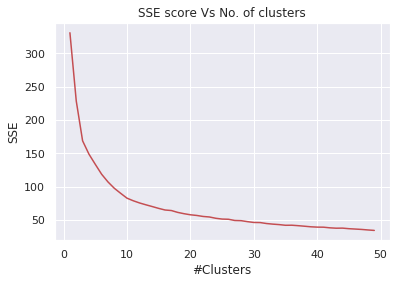

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.8149466192170819
Acc values :  [0.23309608540925267, 0.06583629893238434, 0.8149466192170819, 0.45729537366548045, 0.3096085409252669, 0.11921708185053381]
Acc values :  [[2, 3, 126], [2, 21, 14], [132, 200, 126], [43, 200, 14], [132, 21, 21], [43, 3, 21]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


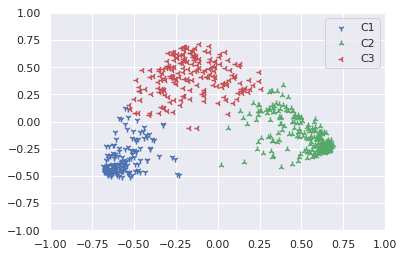

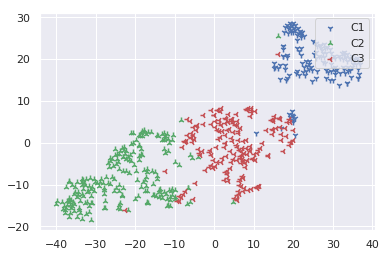

************************************************************
bin:12, thresh:14 
Clustering for 50 clusters ... 


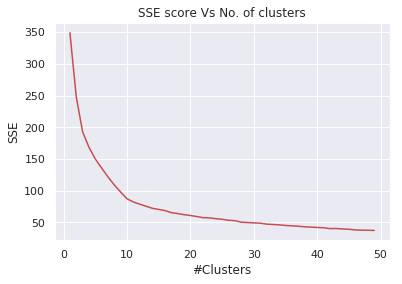

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.7758007117437722
Acc values :  [0.42170818505338076, 0.12633451957295375, 0.09786476868327403, 0.3398576512455516, 0.23843416370106763, 0.7758007117437722]
Acc values :  [[46, 179, 12], [46, 4, 21], [2, 41, 12], [129, 41, 21], [2, 4, 128], [129, 179, 128]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


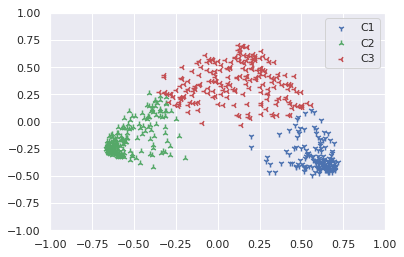

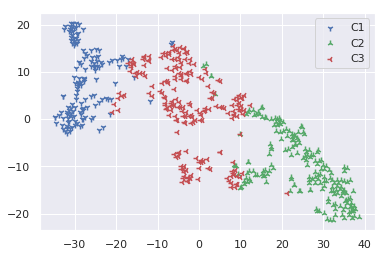

************************************************************
bin:12, thresh:17 
Clustering for 50 clusters ... 


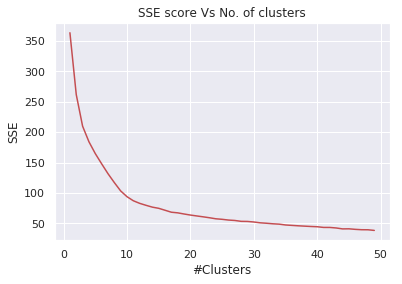

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.7188612099644128
Acc values :  [0.20640569395017794, 0.12277580071174377, 0.7188612099644128, 0.4288256227758007, 0.36476868327402134, 0.1583629893238434]
Acc values :  [[4, 5, 107], [4, 46, 19], [124, 173, 107], [49, 173, 19], [124, 46, 35], [49, 5, 35]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


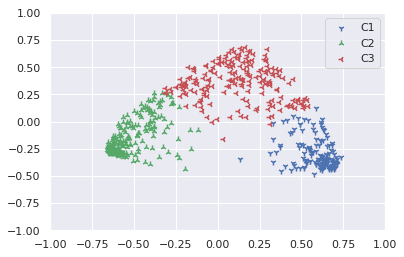

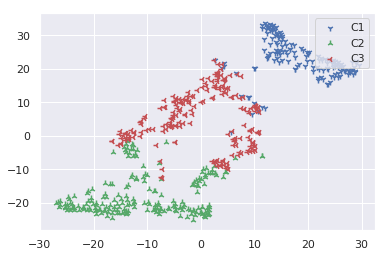

************************************************************
bin:12, thresh:20 
Clustering for 50 clusters ... 


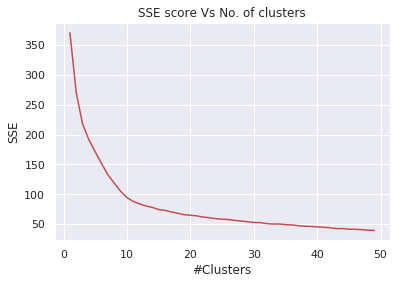

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.6743772241992882
Acc values :  [0.41637010676156583, 0.16370106761565836, 0.1619217081850534, 0.40391459074733094, 0.1797153024911032, 0.6743772241992882]
Acc values :  [[42, 162, 30], [42, 7, 43], [6, 55, 30], [129, 55, 43], [6, 7, 88], [129, 162, 88]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


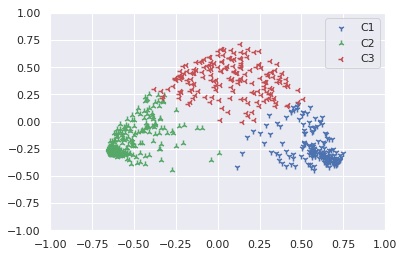

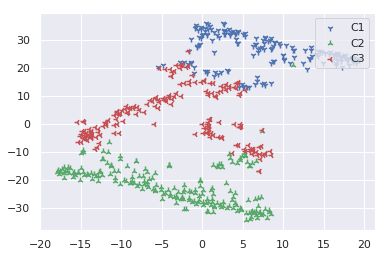

************************************************************
bin:12, thresh:23 
Clustering for 50 clusters ... 


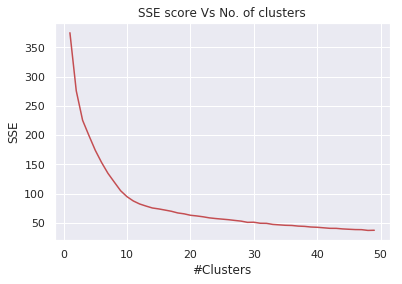

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.6476868327402135
Acc values :  [0.40213523131672596, 0.1797153024911032, 0.17259786476868327, 0.4377224199288256, 0.1601423487544484, 0.6476868327402135]
Acc values :  [[39, 157, 30], [39, 7, 55], [7, 60, 30], [131, 60, 55], [7, 7, 76], [131, 157, 76]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


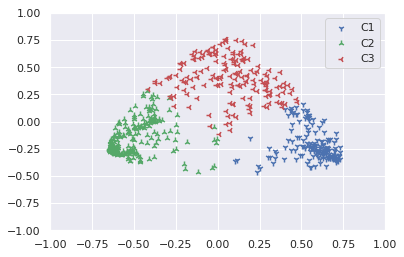

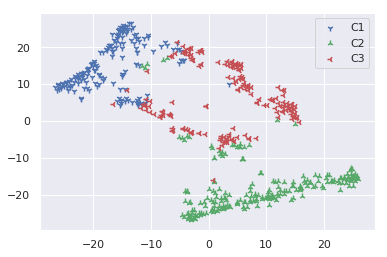

************************************************************
bin:12, thresh:26 
Clustering for 50 clusters ... 


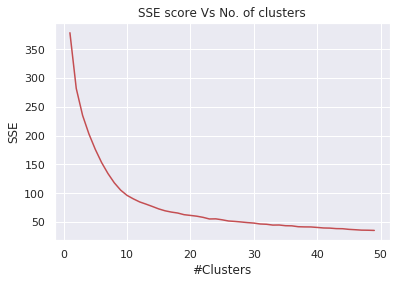

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.6138790035587188
Acc values :  [0.18683274021352314, 0.14412811387900357, 0.3914590747330961, 0.6138790035587188, 0.199288256227758, 0.46441281138790036]
Acc values :  [[8, 63, 34], [8, 11, 62], [36, 150, 34], [133, 150, 62], [36, 11, 65], [133, 63, 65]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


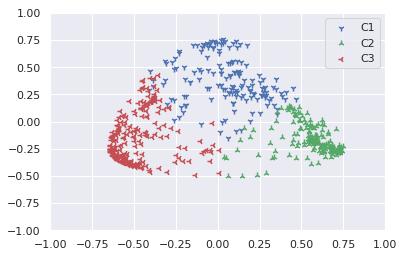

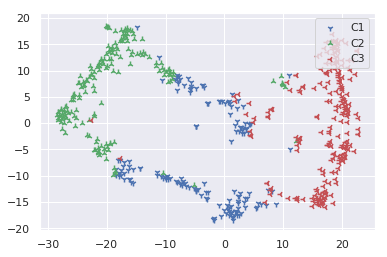

************************************************************
bin:12, thresh:29 
Clustering for 50 clusters ... 


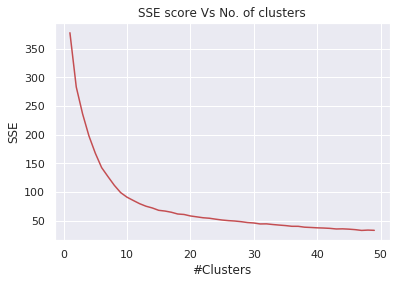

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.5960854092526691
Acc values :  [0.5960854092526691, 0.4501779359430605, 0.13523131672597866, 0.22419928825622776, 0.1797153024911032, 0.41459074733096085]
Acc values :  [[125, 157, 53], [125, 55, 73], [11, 12, 53], [41, 12, 73], [11, 55, 35], [41, 157, 35]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


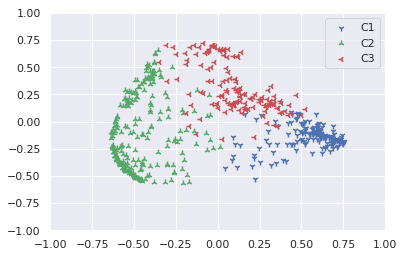

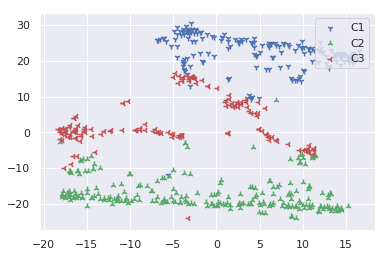

************************************************************
bin:14, thresh:2 
Clustering for 50 clusters ... 


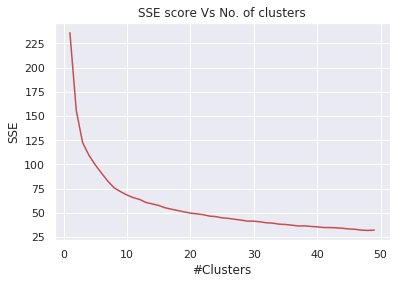

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.8380782918149466
Acc values :  [0.07651245551601424, 0.2313167259786477, 0.4483985765124555, 0.8380782918149466, 0.08540925266903915, 0.3202846975088968]
Acc values :  [[2, 18, 23], [2, 5, 123], [28, 201, 23], [147, 201, 123], [28, 5, 15], [147, 18, 15]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


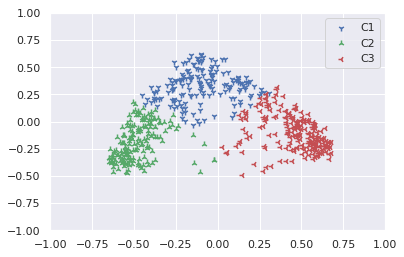

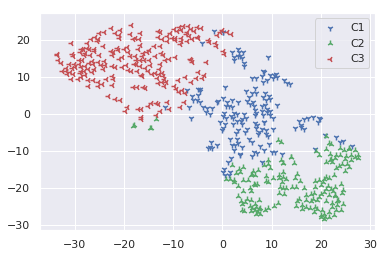

************************************************************
bin:14, thresh:5 
Clustering for 50 clusters ... 


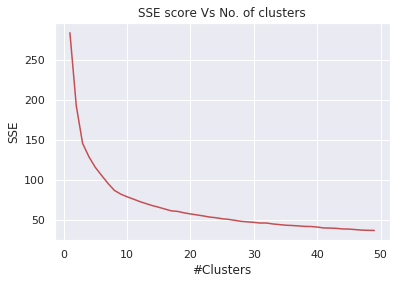

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.8469750889679716
Acc values :  [0.4501779359430605, 0.07829181494661921, 0.07473309608540925, 0.3220640569395018, 0.2277580071174377, 0.8469750889679716]
Acc values :  [[25, 203, 25], [25, 5, 14], [1, 16, 25], [151, 16, 14], [1, 5, 122], [151, 203, 122]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


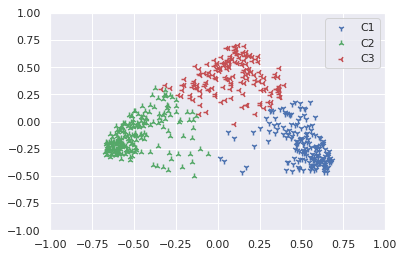

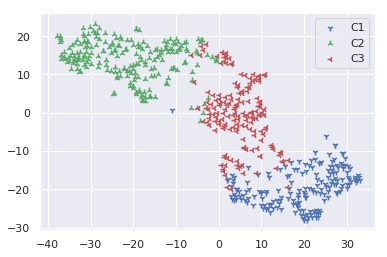

************************************************************
bin:14, thresh:8 
Clustering for 50 clusters ... 


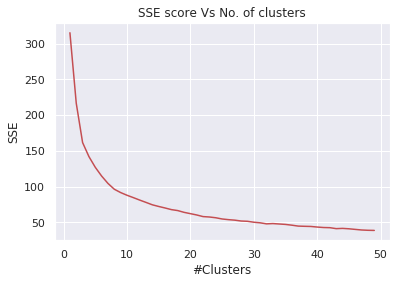

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.8309608540925267
Acc values :  [0.8309608540925267, 0.33274021352313166, 0.22419928825622776, 0.09786476868327403, 0.0711743772241993, 0.4430604982206406]
Acc values :  [[146, 201, 120], [146, 19, 22], [2, 4, 120], [29, 4, 22], [2, 19, 19], [29, 201, 19]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


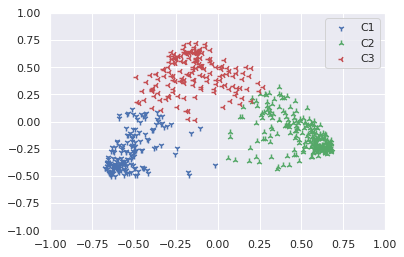

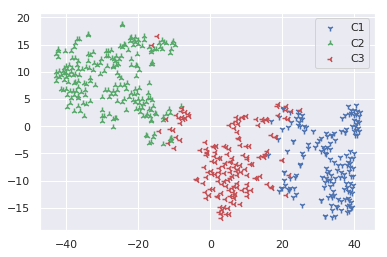

************************************************************
bin:14, thresh:11 
Clustering for 50 clusters ... 


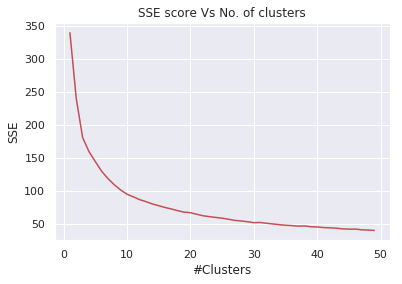

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.8149466192170819
Acc values :  [0.06583629893238434, 0.2313167259786477, 0.4555160142348754, 0.8149466192170819, 0.11921708185053381, 0.31316725978647686]
Acc values :  [[1, 22, 14], [1, 3, 126], [43, 199, 14], [133, 199, 126], [43, 3, 21], [133, 22, 21]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


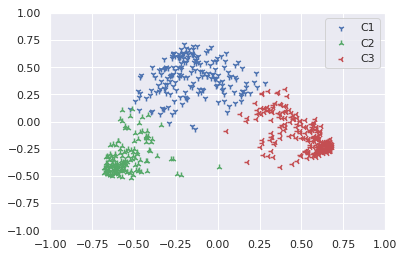

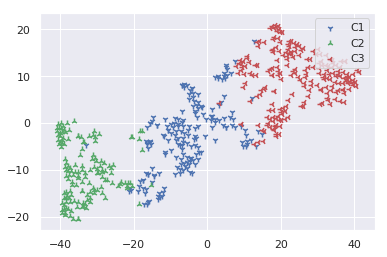

************************************************************
bin:14, thresh:14 
Clustering for 50 clusters ... 


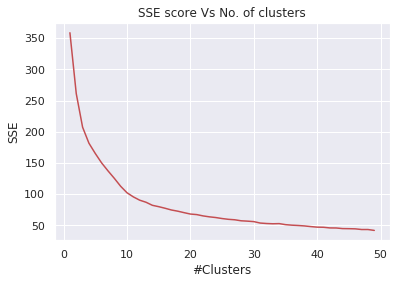

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.7882562277580071
Acc values :  [0.23487544483985764, 0.08362989323843416, 0.7882562277580071, 0.43416370106761565, 0.3309608540925267, 0.12811387900355872]
Acc values :  [[3, 4, 125], [3, 32, 12], [130, 188, 125], [44, 188, 12], [130, 32, 24], [44, 4, 24]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


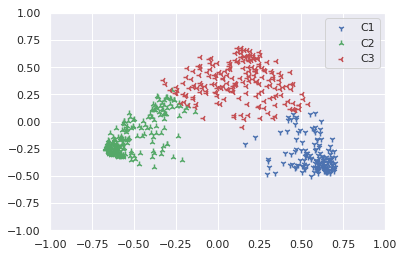

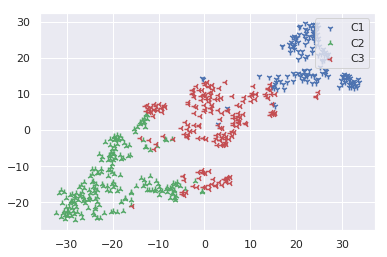

************************************************************
bin:14, thresh:17 
Clustering for 50 clusters ... 


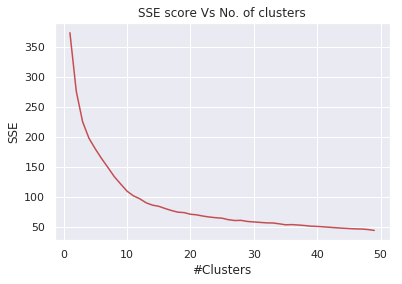

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.699288256227758
Acc values :  [0.20462633451957296, 0.14056939501779359, 0.699288256227758, 0.42170818505338076, 0.3736654804270463, 0.1601423487544484]
Acc values :  [[4, 4, 107], [4, 55, 20], [121, 165, 107], [52, 165, 20], [121, 55, 34], [52, 4, 34]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


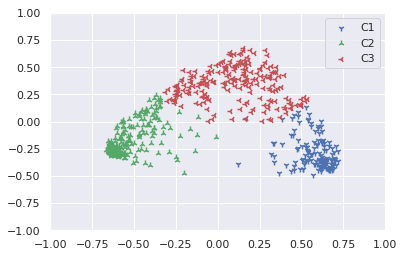

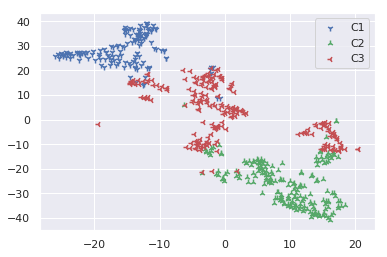

************************************************************
bin:14, thresh:20 
Clustering for 50 clusters ... 


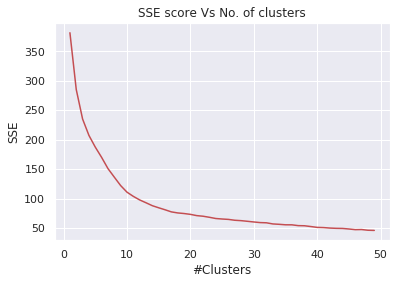

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.6530249110320284
Acc values :  [0.1601423487544484, 0.3932384341637011, 0.42704626334519574, 0.18683274021352314, 0.6530249110320284, 0.1797153024911032]
Acc values :  [[41, 7, 42], [41, 149, 31], [130, 68, 42], [6, 68, 31], [130, 149, 88], [6, 7, 88]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


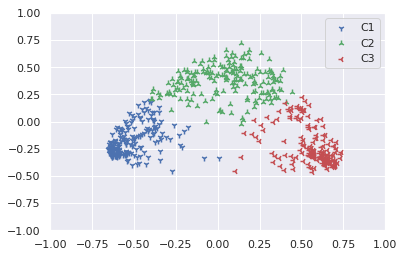

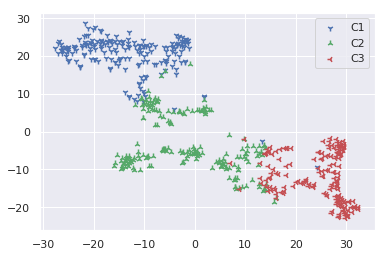

************************************************************
bin:14, thresh:23 
Clustering for 50 clusters ... 


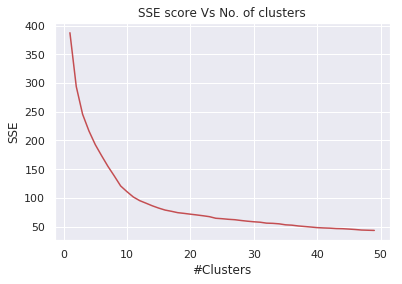

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.6138790035587188
Acc values :  [0.3914590747330961, 0.1797153024911032, 0.20640569395017794, 0.4679715302491103, 0.14056939501779359, 0.6138790035587188]
Acc values :  [[36, 145, 39], [36, 8, 57], [6, 71, 39], [135, 71, 57], [6, 8, 65], [135, 145, 65]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


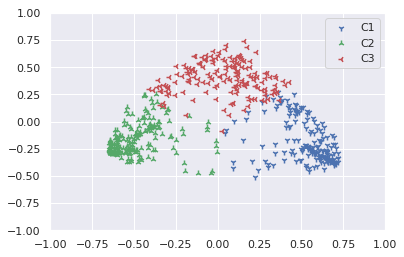

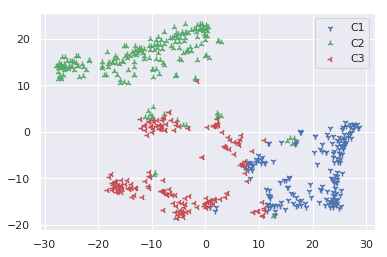

************************************************************
bin:14, thresh:26 
Clustering for 50 clusters ... 


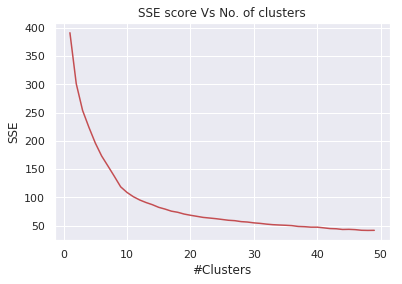

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.5711743772241993
Acc values :  [0.47686832740213525, 0.5711743772241993, 0.2117437722419929, 0.14412811387900357, 0.3790035587188612, 0.21708185053380782]
Acc values :  [[125, 79, 64], [125, 134, 62], [44, 11, 64], [8, 11, 62], [44, 134, 35], [8, 79, 35]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


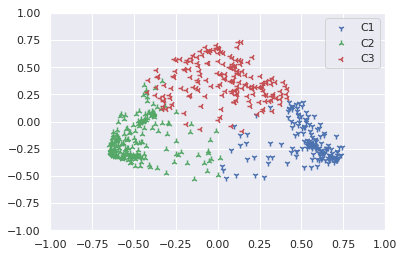

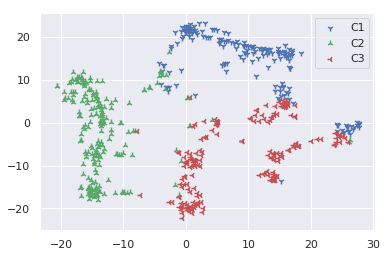

************************************************************
bin:14, thresh:29 
Clustering for 50 clusters ... 


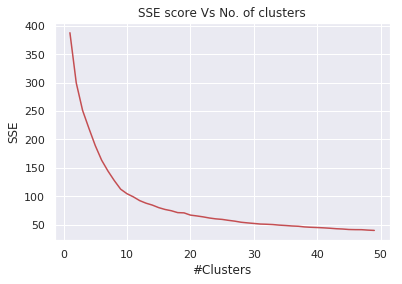

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.5498220640569395
Acc values :  [0.45373665480427045, 0.5498220640569395, 0.24377224199288255, 0.1423487544483986, 0.40391459074733094, 0.20640569395017794]
Acc values :  [[111, 74, 70], [111, 139, 59], [56, 11, 70], [10, 11, 59], [56, 139, 32], [10, 74, 32]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


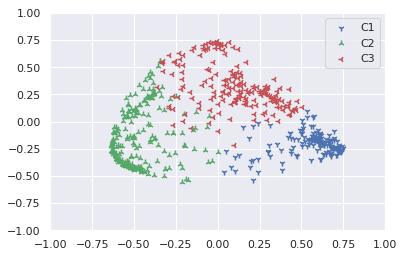

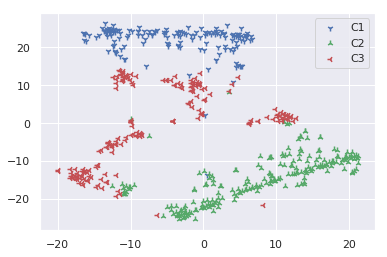

************************************************************
bin:16, thresh:2 
Clustering for 50 clusters ... 


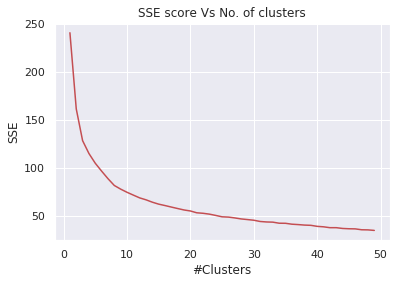

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.8345195729537367
Acc values :  [0.8345195729537367, 0.3167259786476868, 0.22953736654804271, 0.09074733096085409, 0.07473309608540925, 0.45373665480427045]
Acc values :  [[145, 202, 122], [145, 17, 16], [2, 5, 122], [30, 5, 16], [2, 17, 23], [30, 202, 23]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


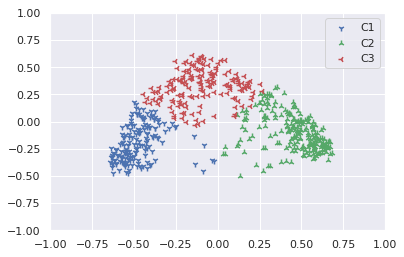

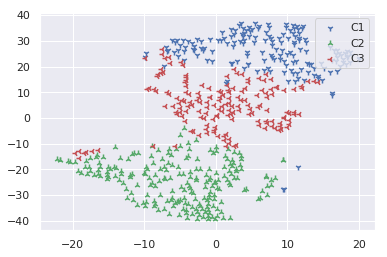

************************************************************
bin:16, thresh:5 
Clustering for 50 clusters ... 


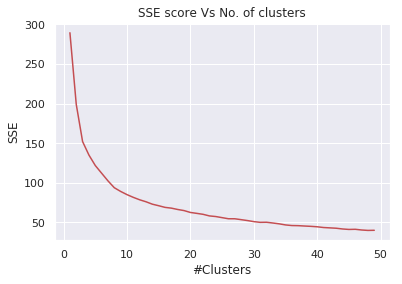

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.8291814946619217
Acc values :  [0.8291814946619217, 0.31494661921708184, 0.2277580071174377, 0.09074733096085409, 0.0800711743772242, 0.45729537366548045]
Acc values :  [[144, 200, 122], [144, 19, 14], [1, 5, 122], [32, 5, 14], [1, 19, 25], [32, 200, 25]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


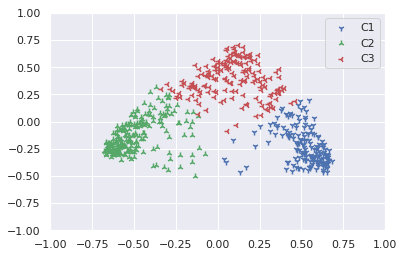

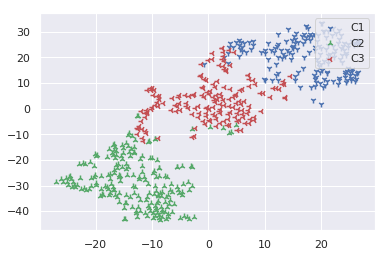

************************************************************
bin:16, thresh:8 
Clustering for 50 clusters ... 


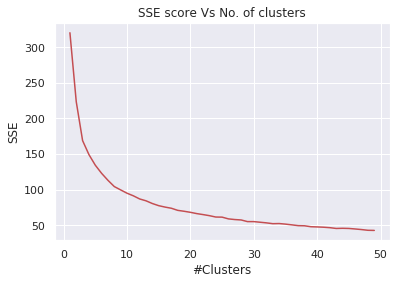

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.8274021352313167
Acc values :  [0.8274021352313167, 0.32562277580071175, 0.22419928825622776, 0.10320284697508897, 0.0693950177935943, 0.4501779359430605]
Acc values :  [[143, 202, 120], [143, 18, 22], [2, 4, 120], [32, 4, 22], [2, 18, 19], [32, 202, 19]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


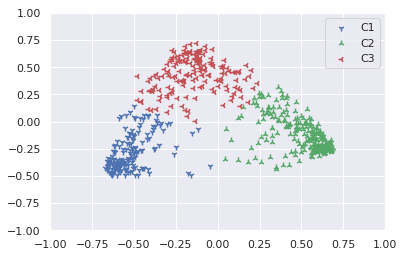

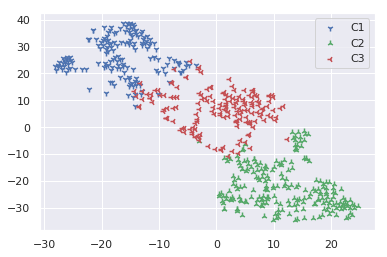

************************************************************
bin:16, thresh:11 
Clustering for 50 clusters ... 


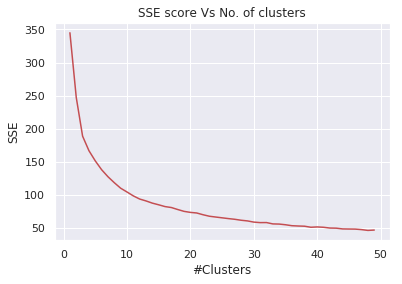

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.8149466192170819
Acc values :  [0.11921708185053381, 0.4555160142348754, 0.31316725978647686, 0.06583629893238434, 0.8149466192170819, 0.2313167259786477]
Acc values :  [[43, 3, 21], [43, 199, 14], [133, 22, 21], [1, 22, 14], [133, 199, 126], [1, 3, 126]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


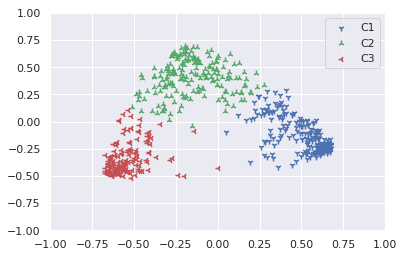

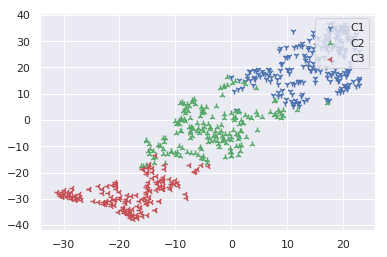

************************************************************
bin:16, thresh:14 
Clustering for 50 clusters ... 


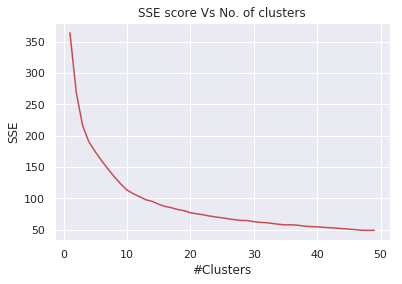

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.7900355871886121
Acc values :  [0.2277580071174377, 0.07829181494661921, 0.7900355871886121, 0.45729537366548045, 0.31494661921708184, 0.13167259786476868]
Acc values :  [[3, 4, 121], [3, 25, 16], [128, 195, 121], [46, 195, 16], [128, 25, 24], [46, 4, 24]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


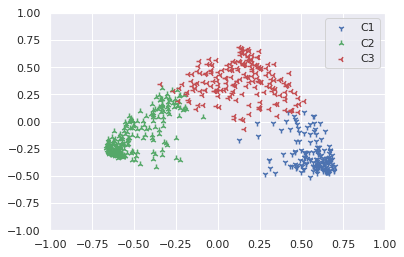

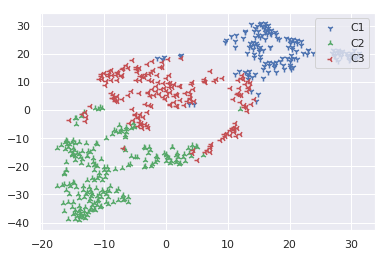

************************************************************
bin:16, thresh:17 
Clustering for 50 clusters ... 


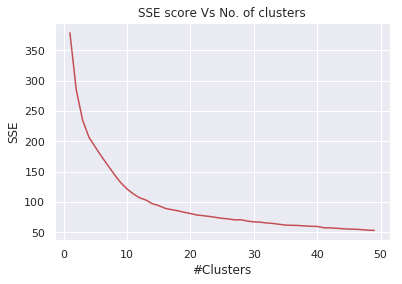

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.6957295373665481
Acc values :  [0.41637010676156583, 0.1601423487544484, 0.14412811387900357, 0.37544483985765126, 0.20818505338078291, 0.6957295373665481]
Acc values :  [[52, 162, 20], [52, 5, 33], [4, 57, 20], [121, 57, 33], [4, 5, 108], [121, 162, 108]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


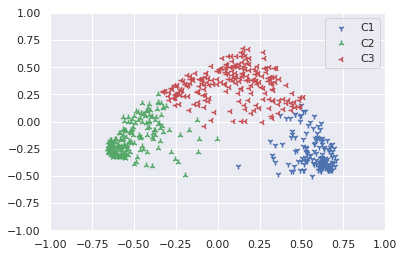

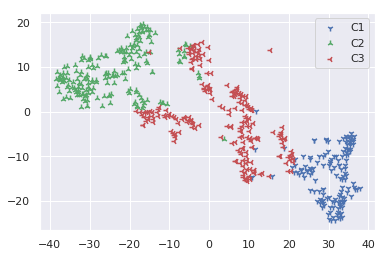

************************************************************
bin:16, thresh:20 
Clustering for 50 clusters ... 


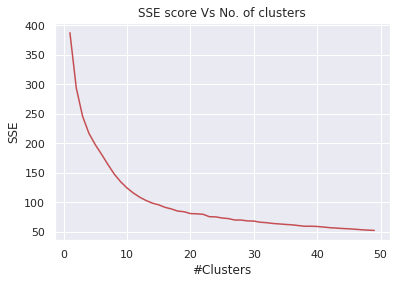

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.6459074733096085
Acc values :  [0.16725978647686832, 0.18861209964412812, 0.41637010676156583, 0.6459074733096085, 0.18683274021352314, 0.39501779359430605]
Acc values :  [[6, 66, 22], [6, 4, 96], [58, 154, 22], [113, 154, 96], [58, 4, 43], [113, 66, 43]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


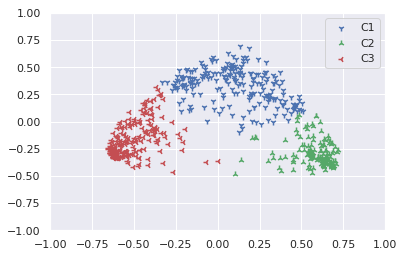

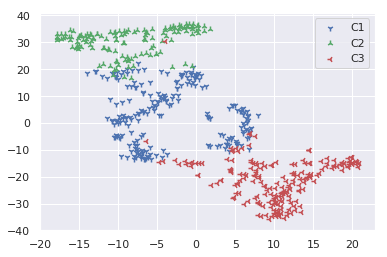

************************************************************
bin:16, thresh:23 
Clustering for 50 clusters ... 


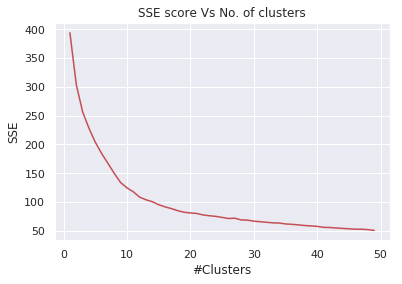

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.6067615658362989
Acc values :  [0.38256227758007116, 0.1797153024911032, 0.21352313167259787, 0.47330960854092524, 0.14412811387900357, 0.6067615658362989]
Acc values :  [[36, 141, 38], [36, 8, 57], [7, 75, 38], [134, 75, 57], [7, 8, 66], [134, 141, 66]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


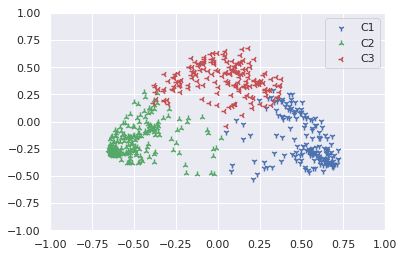

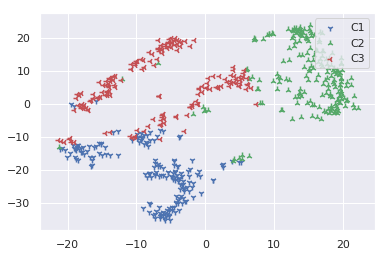

************************************************************
bin:16, thresh:26 
Clustering for 50 clusters ... 


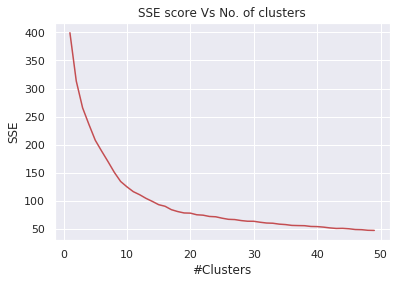

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.5355871886120996
Acc values :  [0.199288256227758, 0.14590747330960854, 0.42526690391459077, 0.5355871886120996, 0.26512455516014233, 0.4288256227758007]
Acc values :  [[8, 76, 28], [8, 9, 65], [72, 139, 28], [97, 139, 65], [72, 9, 68], [97, 76, 68]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


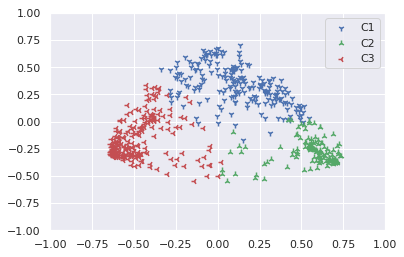

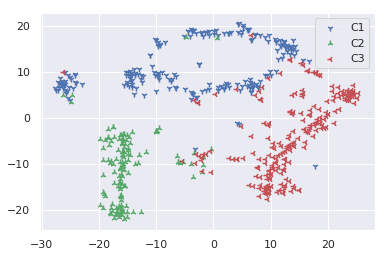

************************************************************
bin:16, thresh:29 
Clustering for 50 clusters ... 


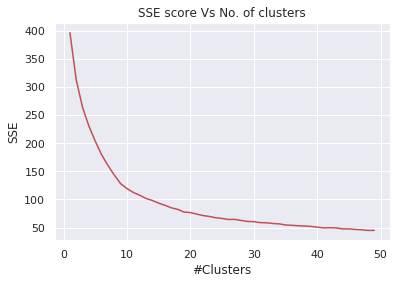

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.5373665480427047
Acc values :  [0.45729537366548045, 0.5373665480427047, 0.24733096085409254, 0.14590747330960854, 0.39679715302491103, 0.21530249110320285]
Acc values :  [[107, 80, 70], [107, 134, 61], [59, 10, 70], [11, 10, 61], [59, 134, 30], [11, 80, 30]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


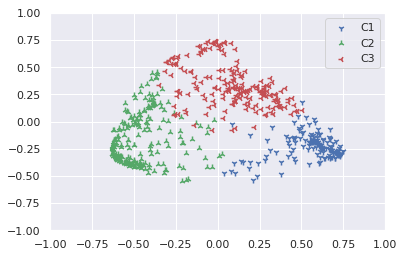

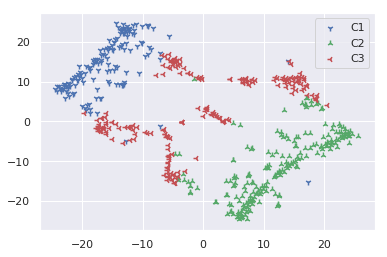

************************************************************
bin:18, thresh:2 
Clustering for 50 clusters ... 


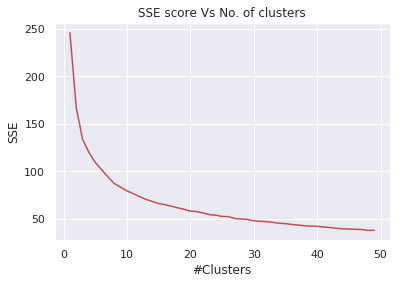

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.8345195729537367
Acc values :  [0.8345195729537367, 0.3220640569395018, 0.2313167259786477, 0.08896797153024912, 0.07651245551601424, 0.44661921708185054]
Acc values :  [[146, 200, 123], [146, 19, 16], [2, 5, 123], [29, 5, 16], [2, 19, 22], [29, 200, 22]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


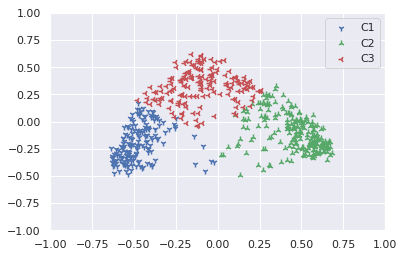

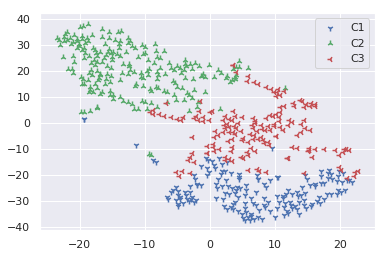

************************************************************
bin:18, thresh:5 
Clustering for 50 clusters ... 


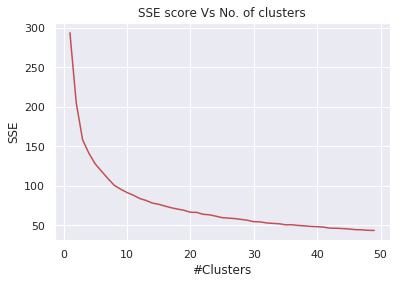

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.8345195729537367
Acc values :  [0.07829181494661921, 0.22953736654804271, 0.45195729537366547, 0.8345195729537367, 0.08718861209964412, 0.3185053380782918]
Acc values :  [[1, 19, 24], [1, 5, 123], [30, 200, 24], [146, 200, 123], [30, 5, 14], [146, 19, 14]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


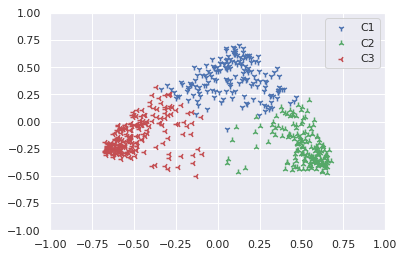

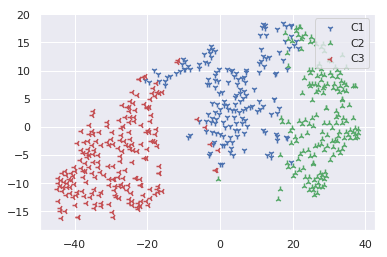

************************************************************
bin:18, thresh:8 
Clustering for 50 clusters ... 


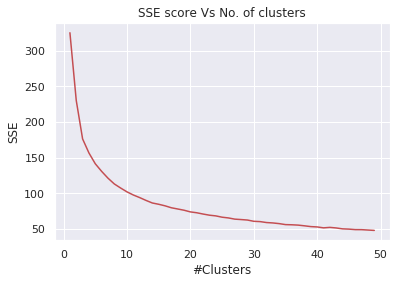

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.8185053380782918
Acc values :  [0.4430604982206406, 0.10142348754448399, 0.0800711743772242, 0.33274021352313166, 0.22419928825622776, 0.8185053380782918]
Acc values :  [[32, 197, 20], [32, 4, 21], [2, 23, 20], [143, 23, 21], [2, 4, 120], [143, 197, 120]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


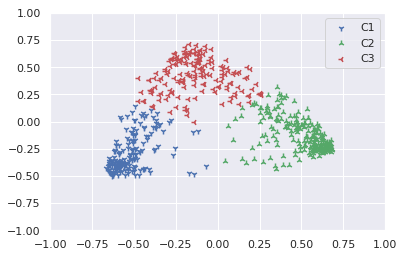

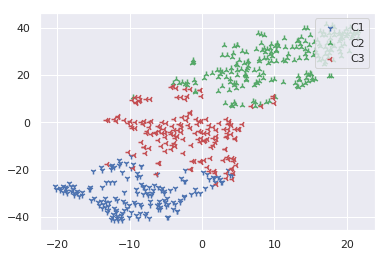

************************************************************
bin:18, thresh:11 
Clustering for 50 clusters ... 


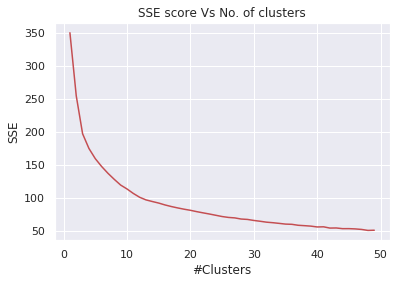

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.8096085409252669
Acc values :  [0.06761565836298933, 0.2313167259786477, 0.45729537366548045, 0.8096085409252669, 0.12277580071174377, 0.3113879003558719]
Acc values :  [[1, 23, 14], [1, 3, 126], [45, 198, 14], [131, 198, 126], [45, 3, 21], [131, 23, 21]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


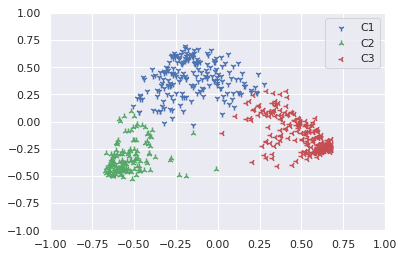

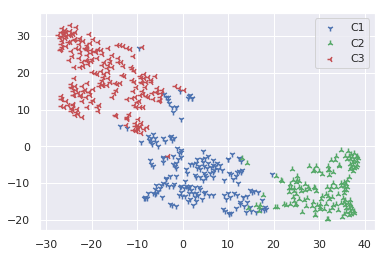

************************************************************
bin:18, thresh:14 
Clustering for 50 clusters ... 


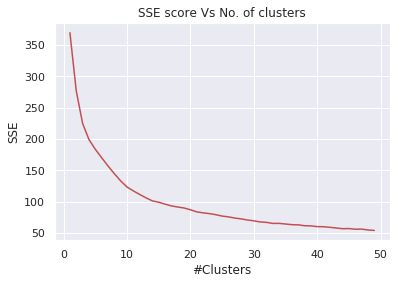

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.7722419928825622
Acc values :  [0.4395017793594306, 0.12811387900355872, 0.099644128113879, 0.3309608540925267, 0.22953736654804271, 0.7722419928825622]
Acc values :  [[46, 184, 17], [46, 4, 22], [3, 36, 17], [128, 36, 22], [3, 4, 122], [128, 184, 122]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


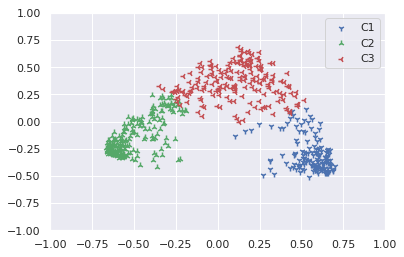

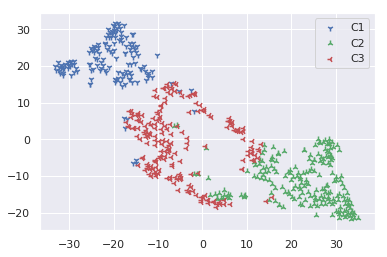

************************************************************
bin:18, thresh:17 
Clustering for 50 clusters ... 


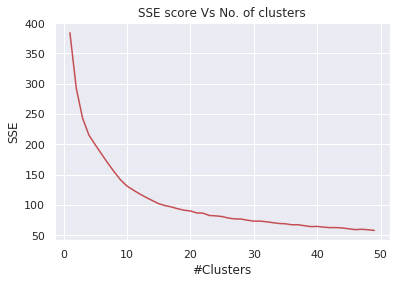

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.6850533807829181
Acc values :  [0.2099644128113879, 0.14768683274021352, 0.6850533807829181, 0.41637010676156583, 0.3736654804270463, 0.16725978647686832]
Acc values :  [[5, 5, 108], [5, 59, 19], [117, 160, 108], [55, 160, 19], [117, 59, 34], [55, 5, 34]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


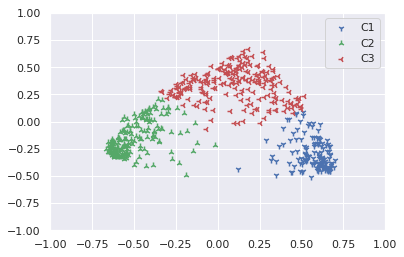

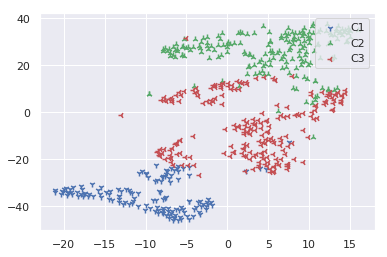

************************************************************
bin:18, thresh:20 
Clustering for 50 clusters ... 


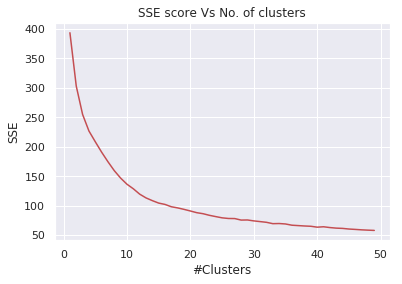

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.6387900355871886
Acc values :  [0.16903914590747332, 0.19395017793594305, 0.41459074733096085, 0.6387900355871886, 0.19217081850533807, 0.3914590747330961]
Acc values :  [[6, 68, 21], [6, 5, 98], [61, 151, 21], [110, 151, 98], [61, 5, 42], [110, 68, 42]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


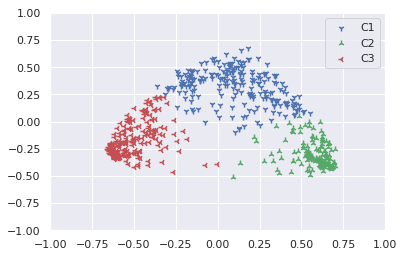

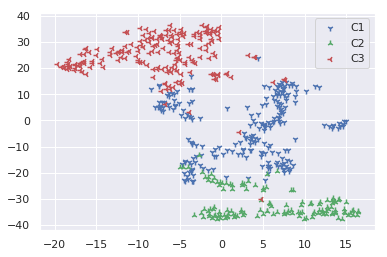

************************************************************
bin:18, thresh:23 
Clustering for 50 clusters ... 


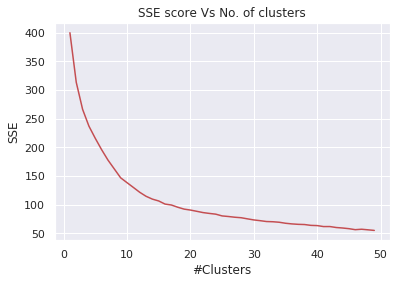

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.5907473309608541
Acc values :  [0.5907473309608541, 0.40569395017793597, 0.16370106761565836, 0.22597864768683273, 0.18327402135231316, 0.4306049822064057]
Acc values :  [[102, 150, 80], [102, 70, 56], [8, 4, 80], [67, 4, 56], [8, 70, 25], [67, 150, 25]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


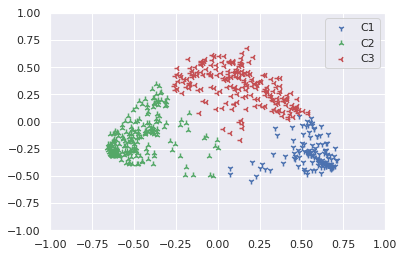

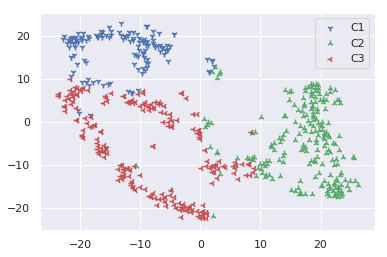

************************************************************
bin:18, thresh:26 
Clustering for 50 clusters ... 


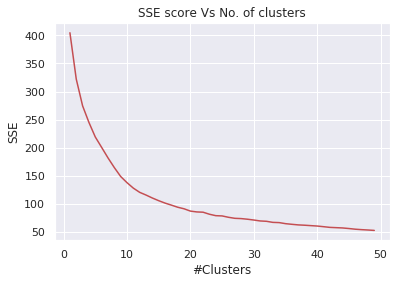

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.5302491103202847
Acc values :  [0.5302491103202847, 0.43416370106761565, 0.14412811387900357, 0.2615658362989324, 0.20818505338078291, 0.42170818505338076]
Acc values :  [[98, 136, 64], [98, 79, 67], [8, 9, 64], [71, 9, 67], [8, 79, 30], [71, 136, 30]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


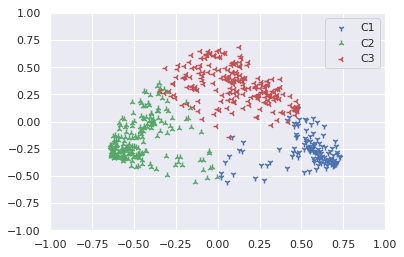

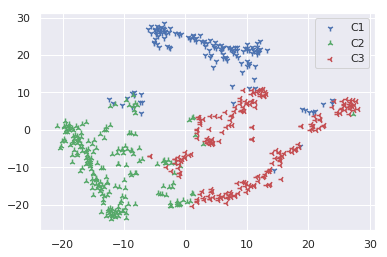

************************************************************
bin:18, thresh:29 
Clustering for 50 clusters ... 


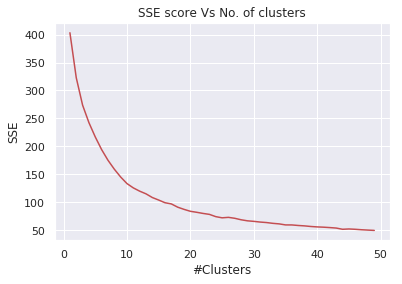

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.5160142348754448
Acc values :  [0.2508896797153025, 0.3736654804270463, 0.4786476868327402, 0.23309608540925267, 0.5160142348754448, 0.14768683274021352]
Acc values :  [[61, 10, 70], [61, 121, 28], [106, 93, 70], [10, 93, 28], [106, 121, 63], [10, 10, 63]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


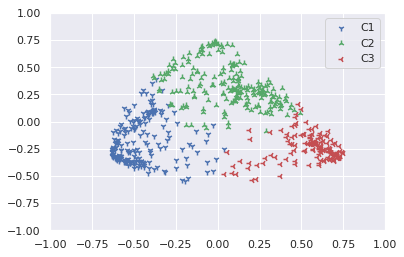

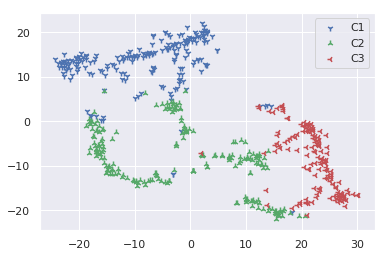

************************************************************
bin:20, thresh:2 
Clustering for 50 clusters ... 


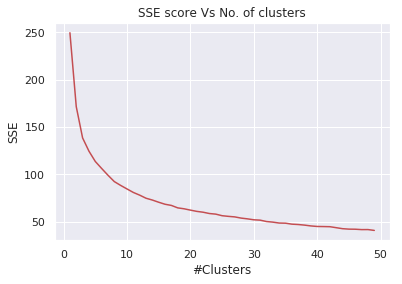

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.8309608540925267
Acc values :  [0.0711743772241993, 0.42170818505338076, 0.33807829181494664, 0.09786476868327403, 0.8309608540925267, 0.2402135231316726]
Acc values :  [[23, 7, 10], [23, 189, 25], [152, 28, 10], [2, 28, 25], [152, 189, 126], [2, 7, 126]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


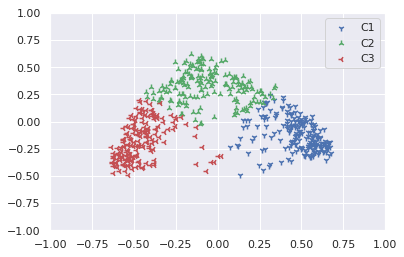

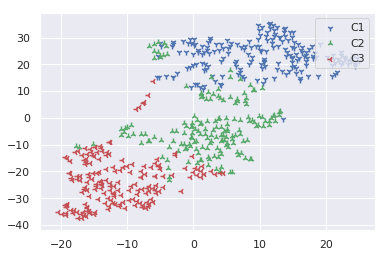

************************************************************
bin:20, thresh:5 
Clustering for 50 clusters ... 


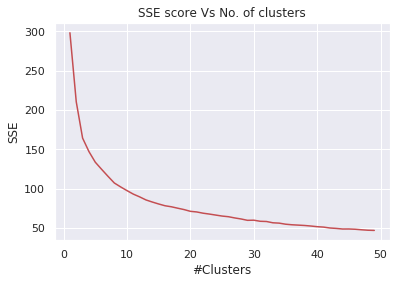

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.8327402135231317
Acc values :  [0.23665480427046262, 0.08540925266903915, 0.8327402135231317, 0.4412811387900356, 0.3220640569395018, 0.08185053380782918]
Acc values :  [[1, 5, 127], [1, 24, 23], [146, 195, 127], [30, 195, 23], [146, 24, 11], [30, 5, 11]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


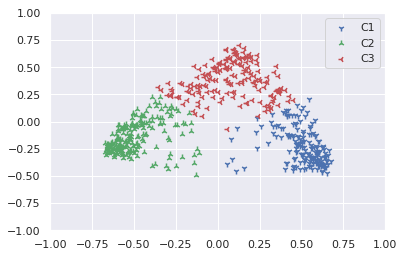

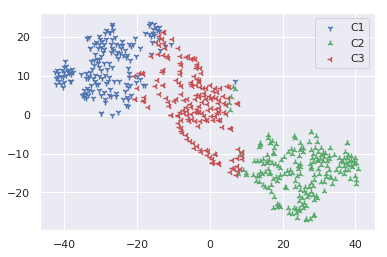

************************************************************
bin:20, thresh:8 
Clustering for 50 clusters ... 


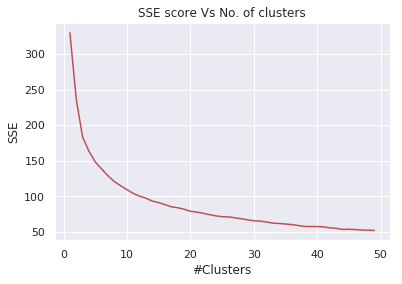

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.8202846975088968
Acc values :  [0.8202846975088968, 0.3274021352313167, 0.22241992882562278, 0.10498220640569395, 0.07473309608540925, 0.4501779359430605]
Acc values :  [[142, 200, 119], [142, 20, 22], [2, 4, 119], [33, 4, 22], [2, 20, 20], [33, 200, 20]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


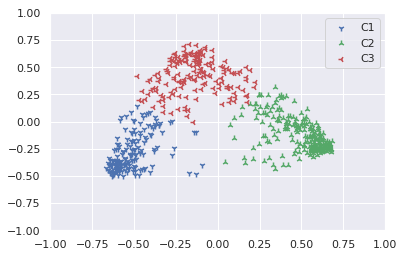

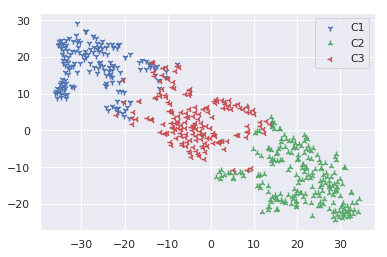

************************************************************
bin:20, thresh:11 
Clustering for 50 clusters ... 


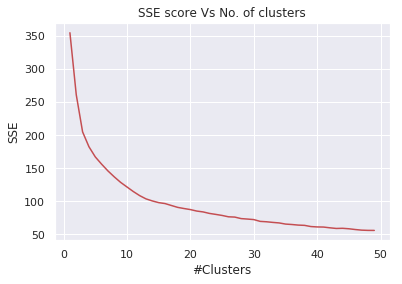

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.806049822064057
Acc values :  [0.45373665480427045, 0.12277580071174377, 0.0711743772241993, 0.31494661921708184, 0.2313167259786477, 0.806049822064057]
Acc values :  [[45, 196, 14], [45, 3, 21], [1, 25, 14], [131, 25, 21], [1, 3, 126], [131, 196, 126]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


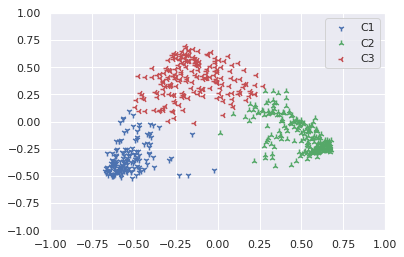

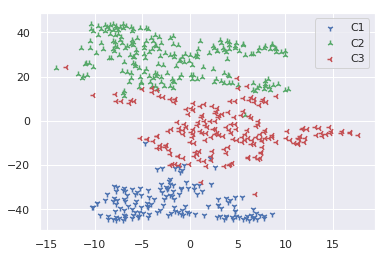

************************************************************
bin:20, thresh:14 
Clustering for 50 clusters ... 


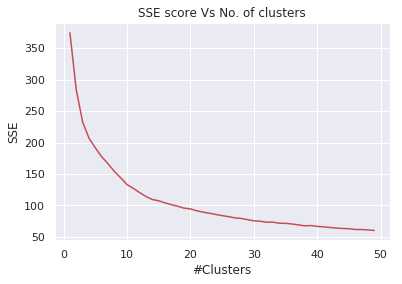

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.7437722419928826
Acc values :  [0.12633451957295375, 0.22953736654804271, 0.4199288256227758, 0.7437722419928826, 0.1298932384341637, 0.3505338078291815]
Acc values :  [[2, 52, 17], [2, 3, 124], [50, 169, 17], [125, 169, 124], [50, 3, 20], [125, 52, 20]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


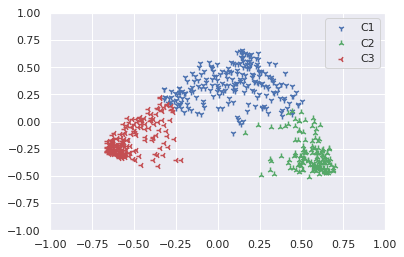

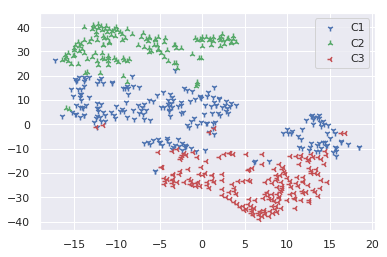

************************************************************
bin:20, thresh:17 
Clustering for 50 clusters ... 


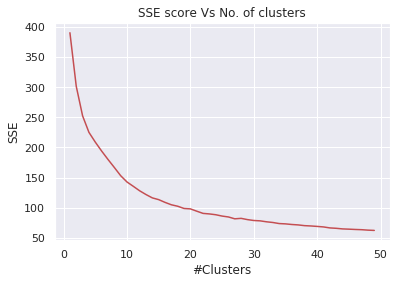

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.6779359430604982
Acc values :  [0.6779359430604982, 0.3701067615658363, 0.20818505338078291, 0.17437722419928825, 0.14768683274021352, 0.42170818505338076]
Acc values :  [[114, 160, 107], [114, 59, 35], [5, 5, 107], [58, 5, 35], [5, 59, 19], [58, 160, 19]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


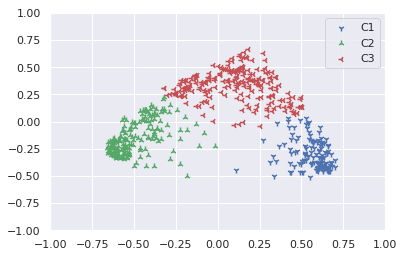

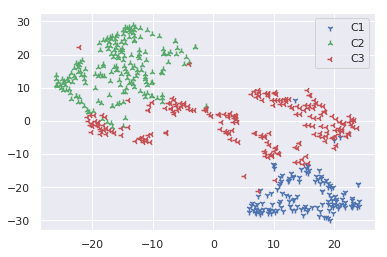

************************************************************
bin:20, thresh:20 
Clustering for 50 clusters ... 


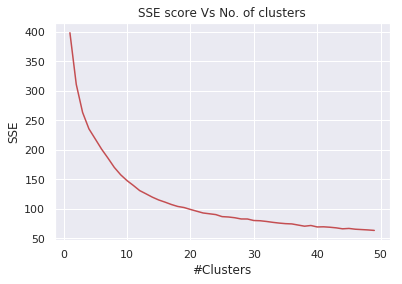

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.6334519572953736
Acc values :  [0.6334519572953736, 0.39501779359430605, 0.1903914590747331, 0.19395017793594305, 0.17259786476868327, 0.41459074733096085]
Acc values :  [[110, 150, 96], [110, 69, 43], [6, 5, 96], [61, 5, 43], [6, 69, 22], [61, 150, 22]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


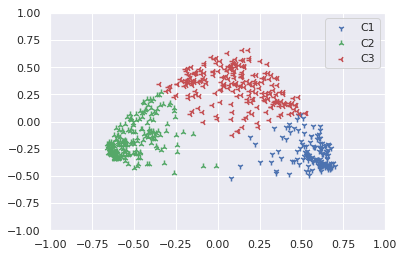

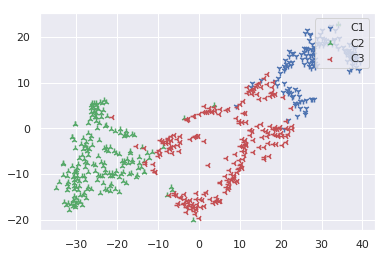

************************************************************
bin:20, thresh:23 
Clustering for 50 clusters ... 


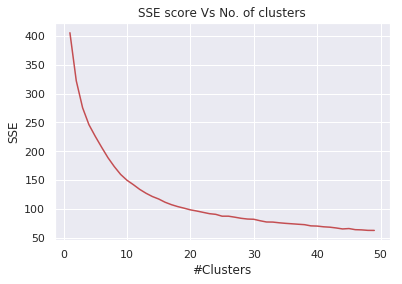

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.5765124555160143
Acc values :  [0.5765124555160143, 0.4092526690391459, 0.16903914590747332, 0.2313167259786477, 0.19217081850533807, 0.42170818505338076]
Acc values :  [[101, 143, 80], [101, 74, 55], [8, 7, 80], [68, 7, 55], [8, 74, 26], [68, 143, 26]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


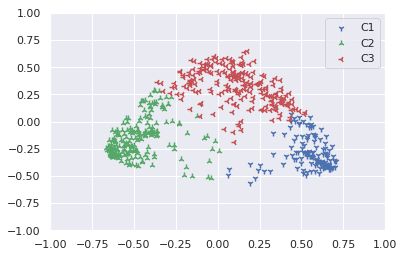

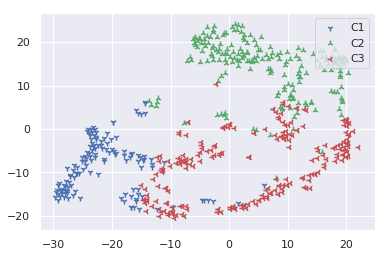

************************************************************
bin:20, thresh:26 
Clustering for 50 clusters ... 


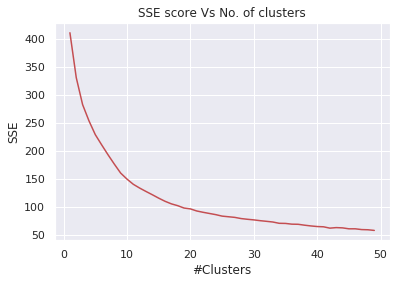

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.5124555160142349
Acc values :  [0.5124555160142349, 0.4359430604982206, 0.14412811387900357, 0.2669039145907473, 0.2206405693950178, 0.4199288256227758]
Acc values :  [[94, 130, 64], [94, 85, 66], [8, 9, 64], [75, 9, 66], [8, 85, 31], [75, 130, 31]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


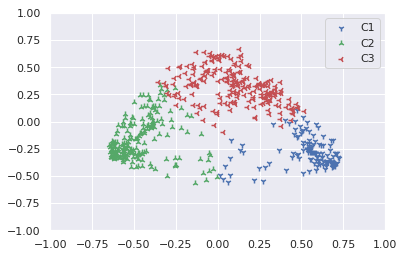

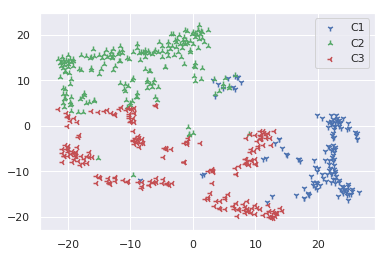

************************************************************
bin:20, thresh:29 
Clustering for 50 clusters ... 


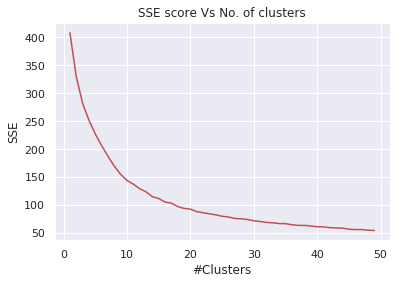

Final clustering for 3 clusters... 

Read 562 ground truth stroke labels from file.
Length of pred_keys 562 :: Length of gt_keys 562 :: Length of pred_values 562
Max Acc. :  0.5106761565836299
Acc values :  [0.1494661921708185, 0.23665480427046262, 0.5106761565836299, 0.3736654804270463, 0.47686832740213525, 0.2526690391459075]
Acc values :  [[10, 9, 65], [10, 96, 27], [103, 119, 65], [64, 119, 27], [103, 96, 69], [64, 9, 69]]
perm_tuples :  [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


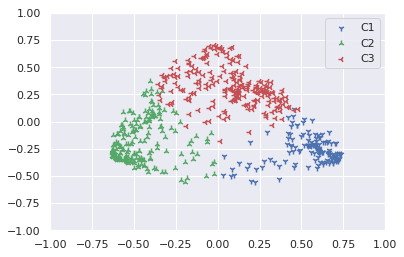

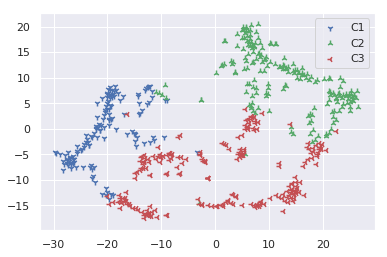

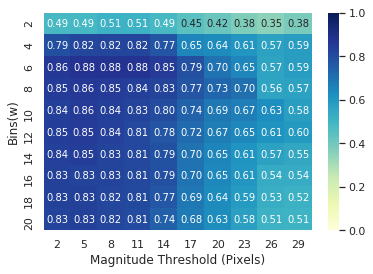

In [19]:
if __name__ == '__main__':
    
    bin_counts = list(range(2, 21, 2))
    thresh_list = list(range(2, 30, 3))
    
    bins_vals = []
    thresh_vals = []
    best_acc = []
    
    for bins in bin_counts:
        for thresh in thresh_list:
            print(60*'*')
            #all_feats = extract_all_feats(DATASET, LABELS, bins, thresh)
            #all_feats[np.isinf(all_feats)] = 0
            destPath = os.path.join(RESULTS_DIR, "bins_"+str(bins)+"_th_"+str(thresh))
            #if not os.path.exists(destPath):
            #    os.makedirs(destPath)
            #np.save(os.path.join(destPath, "feats_bins"+str(bins)+"_th_"+str(thresh)+".npy"), all_feats)
            all_feats = np.load(os.path.join(destPath, "feats_bins"+str(bins)+"_th_"+str(thresh)+".npy"))
            print("bin:{}, thresh:{} ".format(bins, thresh))
            all_feats = normalize(all_feats, norm='l2')
            ###################################################################################
            #all_feats = np.load(os.path.join("flow_shot", "norm_train_feats_50.npy"))
            
            sse_list = []
            x_range = list(range(1, 50))
            print("Clustering for 50 clusters ... ")
            for i in x_range:
                km = kmeans(all_feats, i)
                labels = km.labels_
                sse_list.append(km.inertia_)
                #print("labels_", labels)
            
            plot_sse_score(sse_list, x_range, bins, thresh)
            print("Final clustering for 3 clusters... \n")
            
            km = kmeans(all_feats, 3)
            labels = km.labels_
    
            acc_values, perm_tuples, gt_list, pred_list = get_accuracy(all_feats, labels, ANNOTATION_FILE)
            acc_perc = [sum(k)/all_feats.shape[0] for k in acc_values]
            #best_acc[i,j] = max(acc_perc)
            bins_vals.append(bins)
            thresh_vals.append(thresh)
            best_acc.append(max(acc_perc))
            best_indx = acc_perc.index(max(acc_perc))
            print("Max Acc. : ", max(acc_perc))
            print("Acc values : ", acc_perc)
            print("Acc values : ", acc_values)
            print("perm_tuples : ", perm_tuples)
            
            if bins>2:
                pca_flows = apply_PCA(all_feats)
            else:
                pca_flows = all_feats
            plot_clusters(pca_flows, labels, perm_tuples[best_indx], bins, thresh, 'cluster_pca_ordered.png')
            
            pca_flows = apply_tsne(all_feats)
            plot_clusters(pca_flows, labels, perm_tuples[best_indx], bins, thresh, 'cluster_tsne_ordered.png')
            
            #evaluate(labels, bins, thresh)
            
    
    df = pd.DataFrame({"Bins(w)": bins_vals, "Magnitude Threshold (Pixels)":thresh_vals, "Accuracy(percent)":best_acc})
    df = df.pivot("Bins(w)", "Magnitude Threshold (Pixels)", "Accuracy(percent)")
    ax = sns.heatmap(df, vmin=0., vmax=1., annot=True, fmt='.2f', cmap="YlGnBu")
    
    

In [20]:
best_acc

[0.48576512455516013,
 0.49110320284697506,
 0.5142348754448398,
 0.5124555160142349,
 0.48576512455516013,
 0.44661921708185054,
 0.4181494661921708,
 0.37722419928825623,
 0.35231316725978645,
 0.38434163701067614,
 0.7935943060498221,
 0.8202846975088968,
 0.8238434163701067,
 0.8238434163701067,
 0.7740213523131673,
 0.6494661921708185,
 0.6387900355871886,
 0.608540925266904,
 0.5729537366548043,
 0.5854092526690391,
 0.8612099644128114,
 0.8754448398576512,
 0.8754448398576512,
 0.8772241992882562,
 0.8523131672597865,
 0.791814946619217,
 0.699288256227758,
 0.6494661921708185,
 0.5658362989323843,
 0.5854092526690391,
 0.8505338078291815,
 0.8594306049822064,
 0.8540925266903915,
 0.8434163701067615,
 0.8309608540925267,
 0.7740213523131673,
 0.7277580071174378,
 0.7046263345195729,
 0.5587188612099644,
 0.5711743772241993,
 0.8434163701067615,
 0.8558718861209964,
 0.8434163701067615,
 0.8309608540925267,
 0.8042704626334519,
 0.7419928825622776,
 0.6868327402135231,
 0.670818

In [21]:
perm_tuples

[(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]

In [22]:
df

Magnitude Threshold (Pixels)        2         5         8         11  \
Bins(w)                                                                
2                             0.485765  0.491103  0.514235  0.512456   
4                             0.793594  0.820285  0.823843  0.823843   
6                             0.861210  0.875445  0.875445  0.877224   
8                             0.850534  0.859431  0.854093  0.843416   
10                            0.843416  0.855872  0.843416  0.830961   
12                            0.845196  0.852313  0.836299  0.814947   
14                            0.838078  0.846975  0.830961  0.814947   
16                            0.834520  0.829181  0.827402  0.814947   
18                            0.834520  0.834520  0.818505  0.809609   
20                            0.830961  0.832740  0.820285  0.806050   

Magnitude Threshold (Pixels)        14        17        20        23  \
Bins(w)                                                                
2                             0.485765  0.446619  0.418149  0.377224   
4                             0.774021  0.649466  0.638790  0.608541   
6                             0.852313  0.791815  0.699288  0.649466   
8                             0.830961  0.774021  0.727758  0.704626   
10                            0.804270  0.741993  0.686833  0.670819   
12                            0.775801  0.718861  0.674377  0.647687   
14                            0.788256  0.699288  0.653025  0.613879   
16                            0.790036  0.695730  0.645907  0.606762   
18                            0.772242  0.685053  0.638790  0.590747   
20                            0.743772  0.677936  0.633452  0.576512   

Magnitude Threshold (Pixels)        26        29  
Bins(w)                                           
2                             0.352313  0.384342  
4                             0.572954  0.585409  
6                             0.565836  0.585409  
8                             0.558719  0.571174  
10                            0.629893  0.580071  
12                            0.613879  0.596085  
14                            0.571174  0.549822  
16                            0.535587  0.537367  
18                            0.530249  0.516014  
20                            0.512456  0.510676

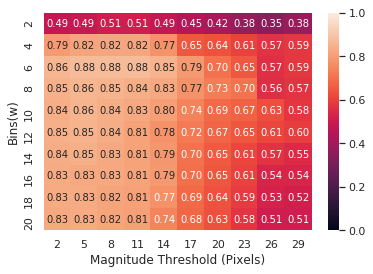

In [23]:
normal_heat = sns.heatmap(df, vmin=0., vmax=1., annot=True, fmt='.2f')

In [25]:
normal_heat.figure.savefig("normal_heat_bins10_thresh10.png")

In [14]:
perm_tuples

[(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]

In [61]:
for i, g in enumerate(gt_list):
    print(g, pred_list[i])

0 1
2 1
1 0
0 1
2 1
1 1
0 2
2 1
0 1
2 1
0 1
2 1
0 2
1 1
2 1
2 1
1 1
0 1
0 1
2 1
0 1
2 1
2 1
2 1
2 1
2 1
1 1
1 1
0 1
1 0
2 1
1 1
2 1
0 1
1 1
2 1
0 1
1 1
2 1
2 1
0 1
1 1
1 1
0 1
1 1
2 1
1 1
1 1
0 1
2 1
1 1
1 0
2 1
2 1
2 1
1 0
0 2
2 1
2 1
1 1
0 1
1 1
2 1
2 1
0 1
0 1
1 1
1 1
0 1
1 0
0 1
1 1
1 0
0 1
0 1
0 1
1 1
1 1
1 0
2 1
2 1
1 1
1 1
2 1
2 1
1 1
0 1
0 1
0 1
1 1
1 1
1 1
0 1
1 0
0 1
1 0
0 1
1 1
2 1
1 1
0 1
0 1
0 1
0 1
2 1
1 0
2 1
0 1
0 1
2 1
0 1
2 1
1 1
1 1
1 1
1 1
2 1
0 1
0 1
1 1
2 1
1 1
1 0
1 1
2 1
1 1
2 1
1 1
2 1
1 1
2 1
1 1
1 1
2 1
2 1
1 1
1 1
2 1
0 1
1 1
1 1
2 1
2 1
1 1
1 1
0 1
0 1
1 0
1 1
2 1
1 1
1 1
0 1
1 0
1 1
1 1
0 1
2 1
1 1
2 1
2 1
0 1
1 1
1 0
2 1
1 0
0 2
0 1
2 1
1 1
1 0
0 1
1 1
0 1
0 1
2 1
2 1
1 1
1 1
0 1
0 1
2 1
1 1
2 1
1 1
0 1
0 1
2 1
2 1
0 1
0 1
1 1
0 1
0 1
1 1
2 1
2 1
1 1
2 1
0 1
1 0
1 1
0 1
0 2
2 1
2 1
1 1
2 1
0 1
2 1
0 1
1 1
0 1
1 1
0 1
2 1
0 1
0 1
2 1
0 1
2 1
0 1
0 1
0 1
2 1
1 1
2 1
1 1
0 1
0 1
0 1
2 1
1 1
2 1
0 1
0 1
1 1
1 1
1 1
2 1
2 1
1 1
2 1
1 1
2 1
1 1
1 1
1 1
1 1
2 1


In [23]:
#m[all_feats[0]>1] = 1
dbs = dbscan(all_feats)
print(dbs.labels_)
#dbs.labels_

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1

In [21]:
len(pred_list)

351

In [18]:
km.inertia_

196927334606.47345

In [17]:
km = kmeans(all_feats, 2)
labels = km.labels_
#pca_flows = apply_PCA(all_feats)
pca_flows = apply_tsne(all_feats)
# print("pca_flows", np.shape(pca_flows))
plot_clusters(pca_flows, labels)

TypeError: plot_clusters() missing 2 required positional arguments: 'bins' and 'thresh'

In [ ]:
km.inertia_

In [15]:
np.linspace(0,1,3)

array([0. , 0.5, 1. ])